# Problem 4: Customer Segmentation for Telecom Company

**Goal:** Partition customers into 4 groups corresponding to service tiers:
- Basic services
- Electronic services  
- Advanced services
- Full services

**Approach:** Unsupervised clustering (KMeans) followed by cluster interpretation and mapping to service tiers.


In [1]:
# Install required packages
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

packages = ["numpy", "pandas", "matplotlib", "seaborn", "plotly", "scikit-learn", "scipy", "gdown", "joblib", "pyarrow"]

for package in packages:
    try:
        __import__(package)
        print(f"✓ {package}")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed")

print("\nAll packages ready!")


✓ numpy
✓ pandas
✓ matplotlib
✓ seaborn
✓ plotly
Installing scikit-learn...
✓ scikit-learn installed
✓ scipy
✓ gdown
✓ joblib
✓ pyarrow

All packages ready!


In [2]:
# A) Setup & Load
import pandas as pd
import numpy as np
import gdown
import warnings
warnings.filterwarnings('ignore')

# Download dataset from Google Drive
file_id = '18jAAq0KsW7p1J1_bWdJCm3vK_Uw7cgl6'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'telecust1000t.csv'

print("Downloading dataset from Google Drive...")
gdown.download(url, output, quiet=False)
print("Download complete!\n")

# Load data
df = pd.read_csv(output)

# Basic inspection
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape} (rows, columns)")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nBasic statistics:")
print(df.describe(include='all'))
print(f"\nDataset info:")
df.info()


Downloading...
From: https://drive.google.com/uc?id=18jAAq0KsW7p1J1_bWdJCm3vK_Uw7cgl6
To: c:\Users\nikim\OneDrive\Desktop\sensor\telecust1000t.csv
100%|██████████| 37.0k/37.0k [00:02<00:00, 18.5kB/s]

Download complete!

DATASET OVERVIEW
Shape: (1000, 12) (rows, columns)

Column names:
['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed', 'employ', 'retire', 'gender', 'reside', 'custcat']

First 5 rows:
   region  tenure  age  marital  address  income  ed  employ  retire  gender  \
0       2      13   44        1        9    64.0   4       5     0.0       0   
1       3      11   33        1        7   136.0   5       5     0.0       0   
2       3      68   52        1       24   116.0   1      29     0.0       1   
3       2      33   33        0       12    33.0   2       0     0.0       1   
4       2      23   30        1        9    30.0   1       2     0.0       0   

   reside  custcat  
0       2        1  
1       6        4  
2       2        3  
3       1        1  
4       4        3  

Data types:
region       int64
tenure       int64
age          int64
marital      int64
address      int64
income     float64
ed           int64
employ       int64
retire    

## B) Exploratory Data Analysis (EDA)

### B1) Missing Values Analysis


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Calculate missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
}).sort_values('Missing %', ascending=False)
missing_df = missing_df[missing_df['Missing Count'] > 0]

print("Missing Values Summary:")
print("="*60)
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
    
    # Visualize missing values
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(missing_df['Column'], missing_df['Missing %'])
    ax.set_xlabel('Missing Percentage (%)', fontsize=12)
    ax.set_title('Missing Values by Column', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(missing_df.iterrows()):
        ax.text(row['Missing %'] + 0.5, i, f"{row['Missing %']:.1f}%", 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('fig_missing_values.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")
    missing_df = pd.DataFrame(columns=['Column', 'Missing Count', 'Missing %'])


Missing Values Summary:
No missing values found in the dataset!


In [4]:
# Try three different imputation strategies (if missing values exist)
if len(missing_df) > 0:
    from sklearn.impute import SimpleImputer, KNNImputer
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols_with_missing = missing_df['Column'].tolist()
    numeric_missing = [col for col in cols_with_missing if col in numeric_cols]
    
    if len(numeric_missing) > 0:
        print("\n" + "="*60)
        print("IMPUTATION STRATEGY COMPARISON")
        print("="*60)
        
        # Strategy 1: Median imputation
        imputer_median = SimpleImputer(strategy='median')
        df_median = df.copy()
        df_median[numeric_missing] = imputer_median.fit_transform(df[numeric_missing])
        
        # Strategy 2: Mean imputation
        imputer_mean = SimpleImputer(strategy='mean')
        df_mean = df.copy()
        df_mean[numeric_missing] = imputer_mean.fit_transform(df[numeric_missing])
        
        # Strategy 3: KNN imputation
        imputer_knn = KNNImputer(n_neighbors=5)
        df_knn = df.copy()
        df_knn[numeric_missing] = imputer_knn.fit_transform(df[numeric_missing])
        
        # Compare statistics
        print("\nOriginal vs Imputed Statistics:")
        for col in numeric_missing[:3]:  # Show first 3 columns
            print(f"\n{col}:")
            print(f"  Original - Mean: {df[col].mean():.2f}, Std: {df[col].std():.2f}")
            print(f"  Median - Mean: {df_median[col].mean():.2f}, Std: {df_median[col].std():.2f}")
            print(f"  Mean - Mean: {df_mean[col].mean():.2f}, Std: {df_mean[col].std():.2f}")
            print(f"  KNN - Mean: {df_knn[col].mean():.2f}, Std: {df_knn[col].std():.2f}")
        
        print("\n" + "="*60)
        print("="*60)
        df_clean = df_median.copy()
        chosen_imputer = imputer_median
    else:
        df_clean = df.copy()
        chosen_imputer = None
else:
    print("No imputation needed - no missing values!")
    df_clean = df.copy()
    chosen_imputer = None


No imputation needed - no missing values!


### B2) Data Types Analysis


In [5]:
# Identify numeric and categorical features
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# Check for identifier columns (high cardinality, unique per row)
identifier_candidates = []
for col in numeric_features + categorical_features:
    unique_ratio = df_clean[col].nunique() / len(df_clean)
    if unique_ratio > 0.95:  # More than 95% unique values
        identifier_candidates.append(col)

print("Data Type Analysis:")
print("="*60)
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

if identifier_candidates:
    print(f"\n⚠️  Potential identifier columns (will exclude from modeling): {identifier_candidates}")
    # Remove identifiers from feature lists
    numeric_features = [col for col in numeric_features if col not in identifier_candidates]
    categorical_features = [col for col in categorical_features if col not in identifier_candidates]

print(f"\nFeatures for modeling:")
print(f"  Numeric: {len(numeric_features)} features")
print(f"  Categorical: {len(categorical_features)} features")

# Remove target if present (custcat)
if 'custcat' in numeric_features:
    numeric_features.remove('custcat')


Data Type Analysis:
Numeric features (12): ['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed', 'employ', 'retire', 'gender', 'reside', 'custcat']

Categorical features (0): []

Features for modeling:
  Numeric: 12 features
  Categorical: 0 features


### B3) Univariate Distributions


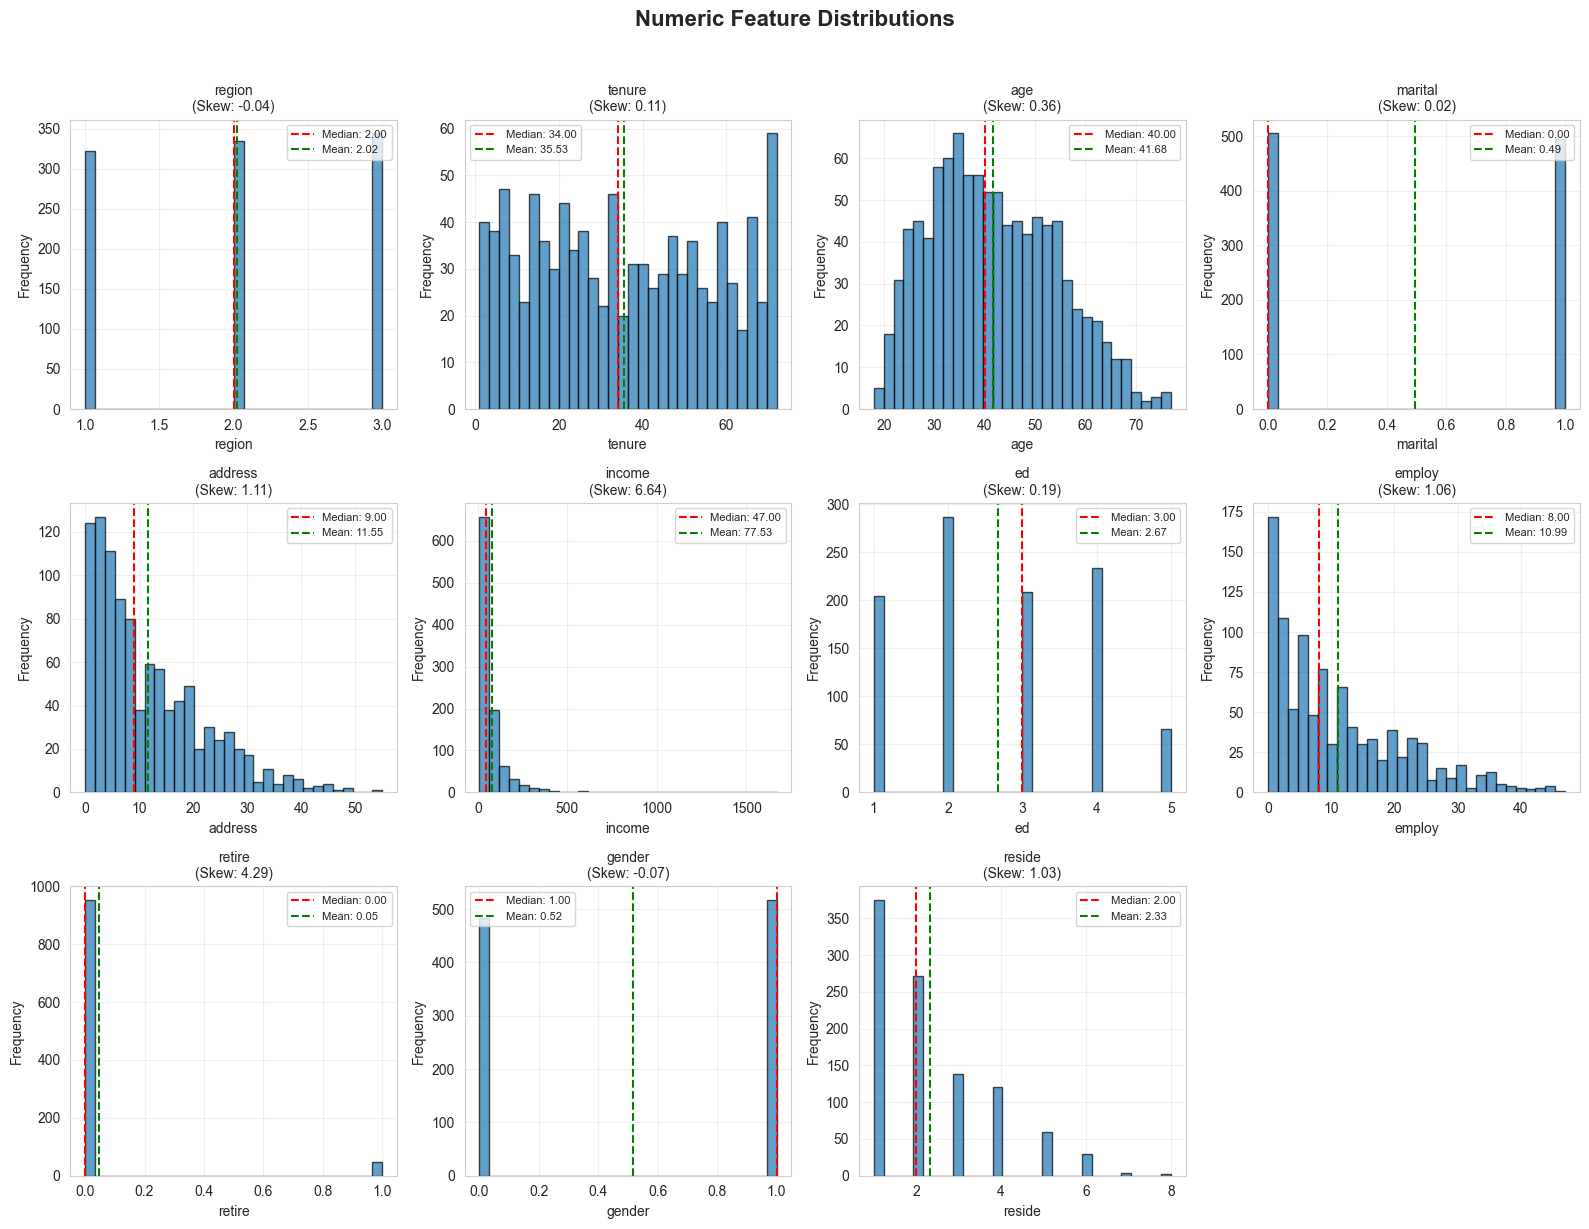

In [6]:
# Numeric: Histograms/KDE plots
n_numeric = len(numeric_features)
n_cols = 4
n_rows = (n_numeric + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten() if n_numeric > 1 else [axes]

for idx, col in enumerate(numeric_features):
    ax = axes[idx]
    df_clean[col].hist(bins=30, ax=ax, alpha=0.7, edgecolor='black')
    ax.axvline(df_clean[col].median(), color='red', linestyle='--', 
               label=f'Median: {df_clean[col].median():.2f}')
    ax.axvline(df_clean[col].mean(), color='green', linestyle='--', 
               label=f'Mean: {df_clean[col].mean():.2f}')
    ax.set_title(f'{col}\n(Skew: {df_clean[col].skew():.2f})', fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide extra subplots
for idx in range(n_numeric, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Numeric Feature Distributions', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()


In [7]:
# Categorical: Value count bar charts
n_categorical = len(categorical_features)
if n_categorical > 0:
    n_cols = 3
    n_rows = (n_categorical + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_categorical > 1 else [axes]
    
    for idx, col in enumerate(categorical_features):
        ax = axes[idx]
        value_counts = df_clean[col].value_counts().head(10)  # Top 10
        value_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
        ax.set_title(f'{col}\n({df_clean[col].nunique()} unique values)', fontsize=10)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
    
    # Hide extra subplots
    for idx in range(n_categorical, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Categorical Feature Distributions', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('fig_categorical_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No categorical features to plot.")


No categorical features to plot.


### B4) Bivariate Relations - Correlation Heatmap


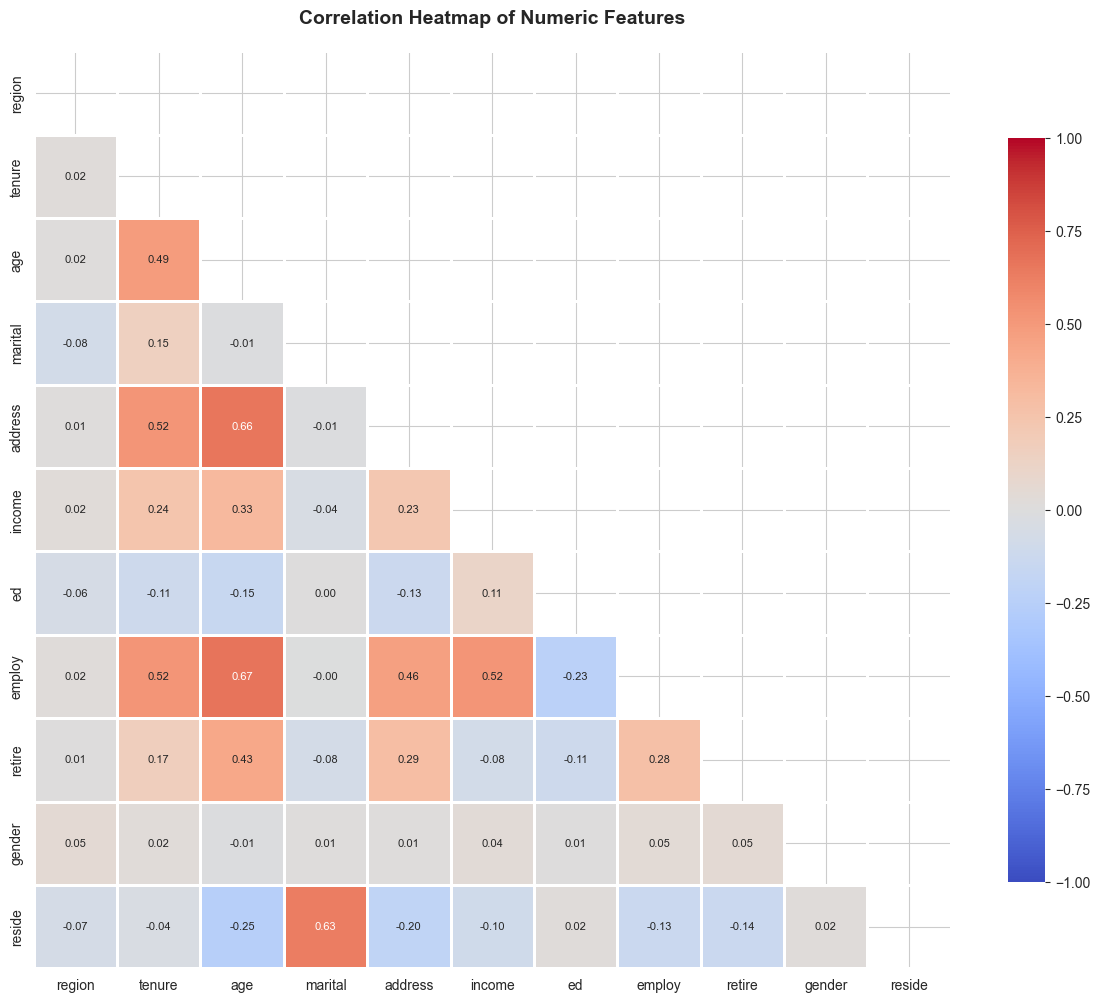


Highly Correlated Feature Pairs (|r| > 0.5):
------------------------------------------------------------
age <-> employ: 0.670
age <-> address: 0.660
marital <-> reside: 0.626
tenure <-> address: 0.523
tenure <-> employ: 0.520
income <-> employ: 0.516


In [8]:
# Correlation heatmap for numeric features
corr_matrix = df_clean[numeric_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 8})
plt.title('Correlation Heatmap of Numeric Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('fig_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Find most correlated pairs
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:  # Threshold for "strong" correlation
            corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

print("\nHighly Correlated Feature Pairs (|r| > 0.5):")
print("-" * 60)
for feat1, feat2, corr in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"{feat1} <-> {feat2}: {corr:.3f}")


### B5) Scatter Plots and Pairplot


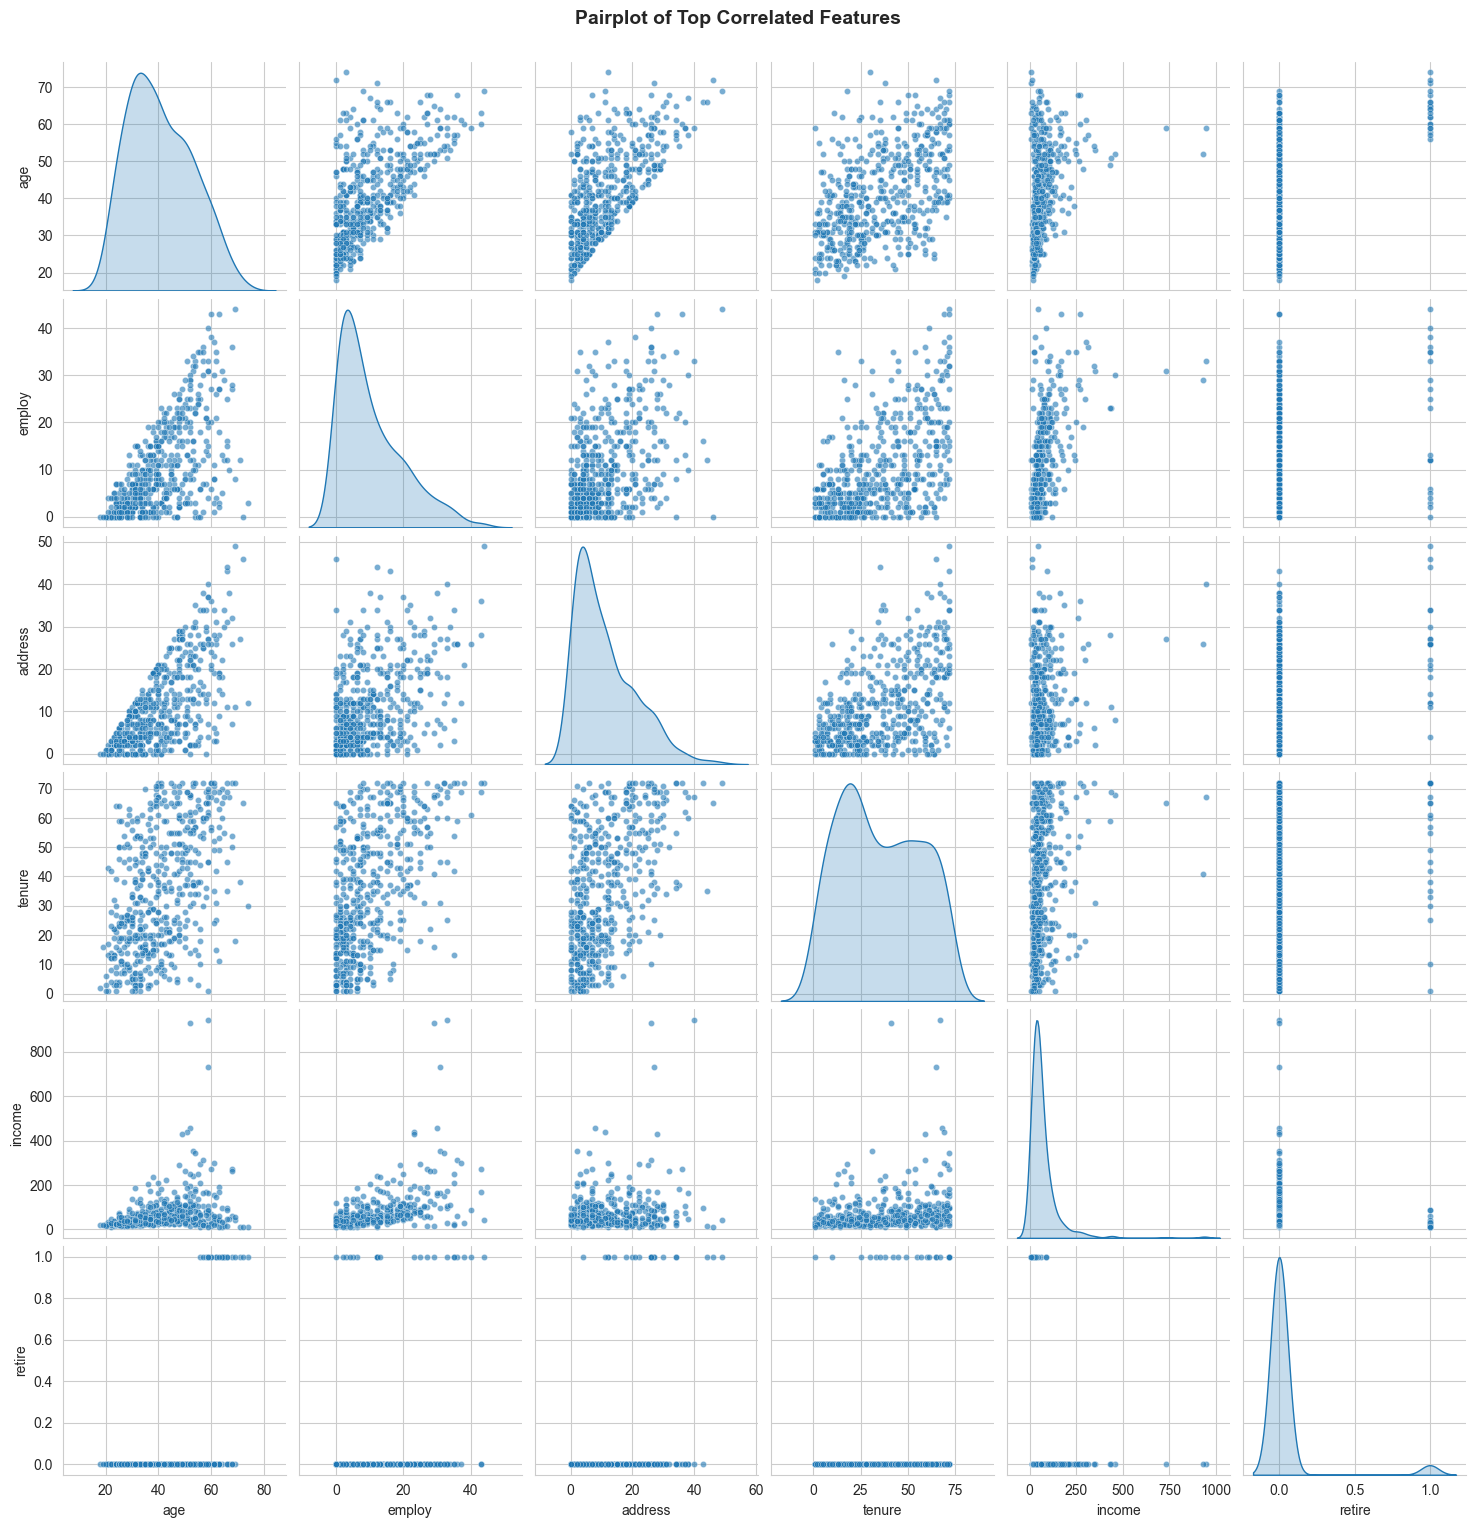

In [9]:
# Select top correlated pairs for detailed visualization
top_features = corr_matrix.abs().sum().nlargest(6).index.tolist()

# Pairplot for top features
if len(top_features) >= 2:
    pairplot_data = df_clean[top_features].sample(min(500, len(df_clean)))  # Sample for speed
    g = sns.pairplot(pairplot_data, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20})
    g.fig.suptitle('Pairplot of Top Correlated Features', fontsize=14, fontweight='bold', y=1.02)
    plt.savefig('fig_pairplot.png', dpi=150, bbox_inches='tight')
    plt.show()


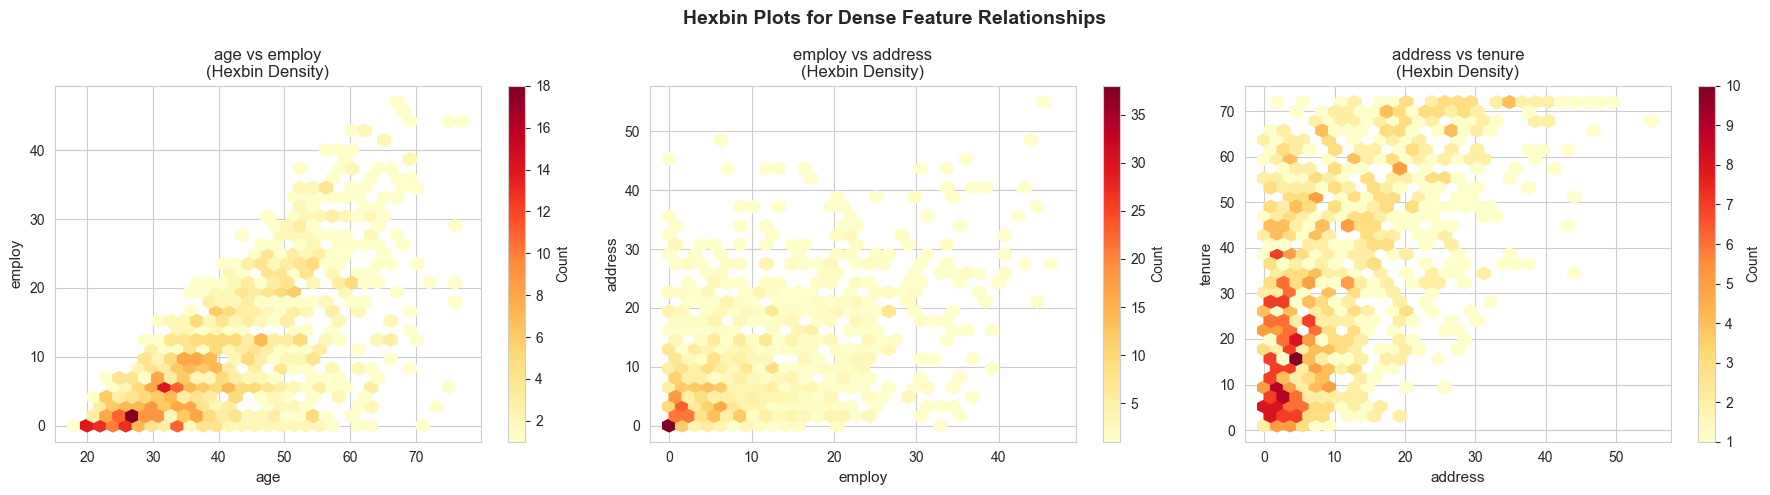

In [10]:
# Hexbin plots for dense 2D relations (top 3 pairs)
if len(top_features) >= 2:
    fig, axes = plt.subplots(1, min(3, len(top_features)-1), figsize=(18, 5))
    if len(top_features) == 2:
        axes = [axes]
    
    for idx in range(min(3, len(top_features)-1)):
        ax = axes[idx] if len(axes) > 1 else axes[0]
        feat1, feat2 = top_features[idx], top_features[idx+1]
        hb = ax.hexbin(df_clean[feat1], df_clean[feat2], gridsize=30, cmap='YlOrRd', mincnt=1)
        ax.set_xlabel(feat1, fontsize=11)
        ax.set_ylabel(feat2, fontsize=11)
        ax.set_title(f'{feat1} vs {feat2}\n(Hexbin Density)', fontsize=12)
        plt.colorbar(hb, ax=ax, label='Count')
    
    plt.suptitle('Hexbin Plots for Dense Feature Relationships', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('fig_hexbin.png', dpi=150, bbox_inches='tight')
    plt.show()
    


### B6) Outlier Detection (Boxplots)


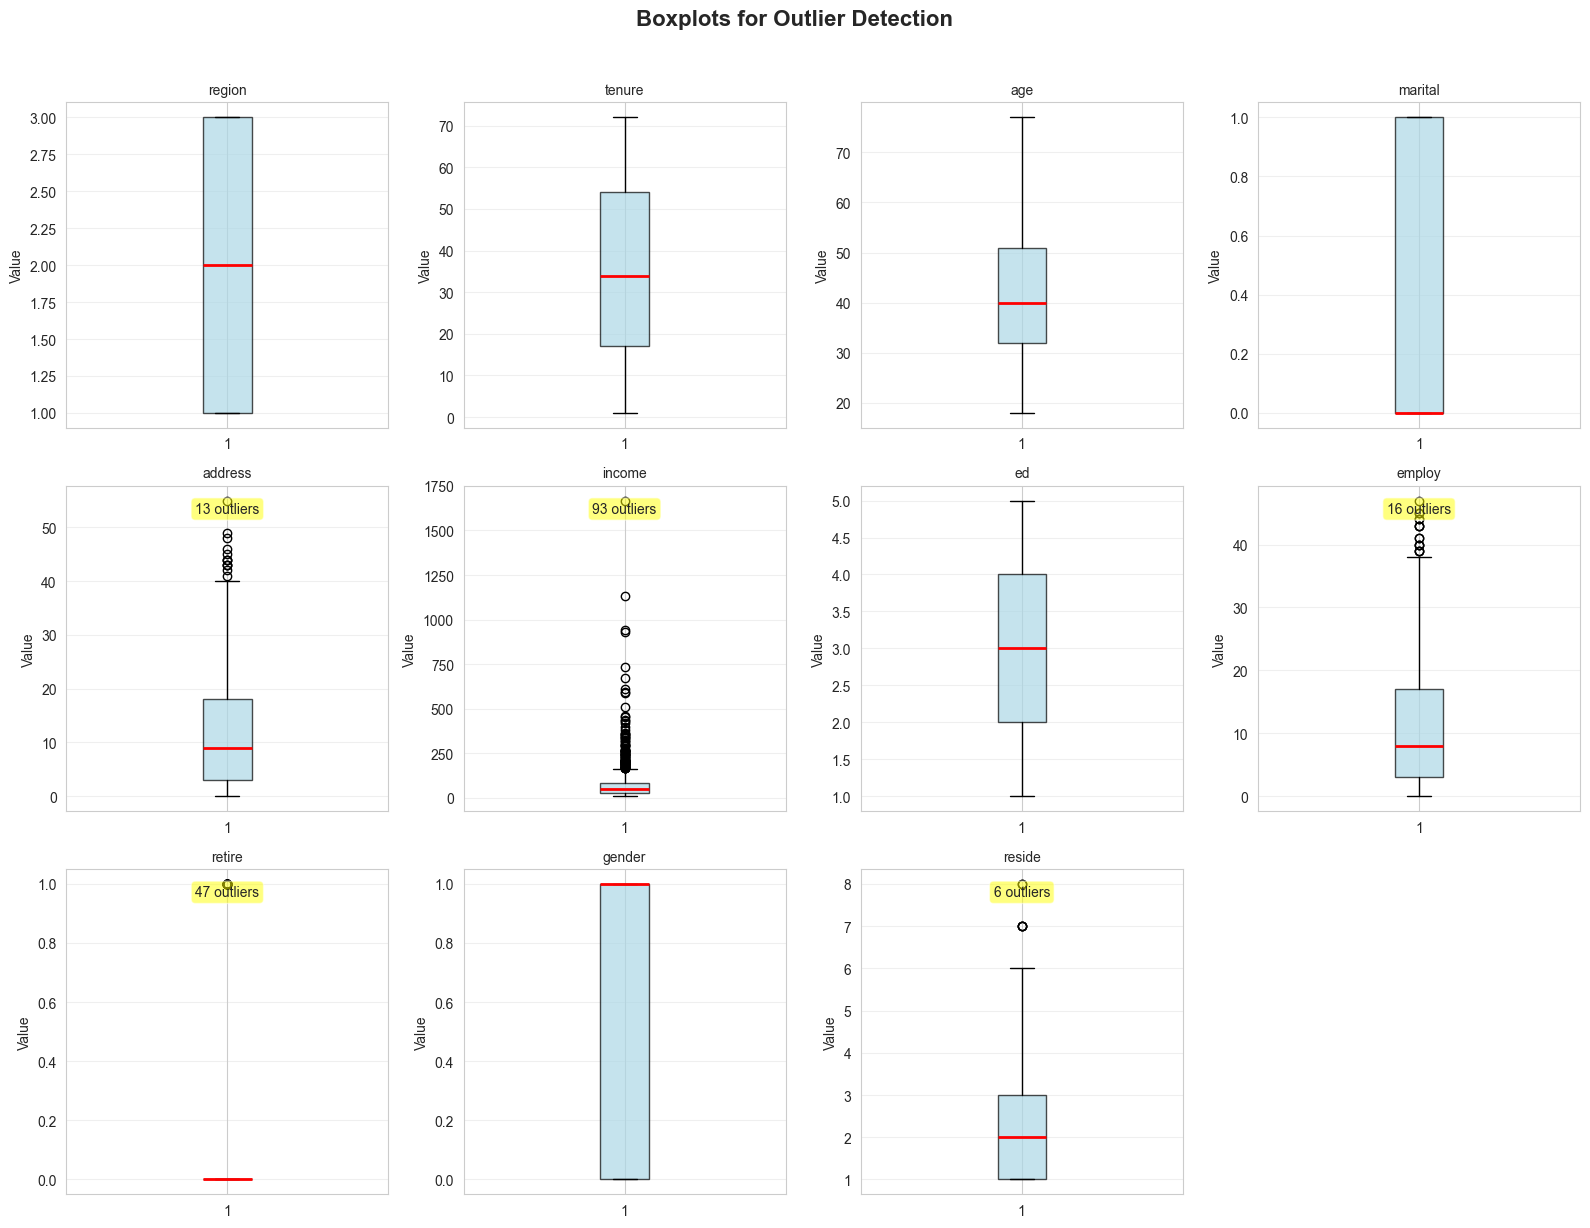

In [11]:
# Boxplots for outlier detection
n_cols = 4
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten() if len(numeric_features) > 1 else [axes]

for idx, col in enumerate(numeric_features):
    ax = axes[idx]
    bp = ax.boxplot(df_clean[col], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    ax.set_title(col, fontsize=10)
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.3)
    
    # Count outliers (beyond 1.5*IQR)
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_clean[col] < (Q1 - 1.5*IQR)) | (df_clean[col] > (Q3 + 1.5*IQR))).sum()
    if outliers > 0:
        ax.text(0.5, 0.95, f'{outliers} outliers', transform=ax.transAxes,
               ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Hide extra subplots
for idx in range(len(numeric_features), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Boxplots for Outlier Detection', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()


## C) Data Cleaning & Feature Preparation


In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Prepare feature lists (excluding identifiers and target if present)
features_for_modeling = numeric_features.copy()

# Create preprocessing pipeline
preprocessing_steps = []

# Numeric: Scale
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Optional: Power transform for highly skewed features
highly_skewed = [col for col in numeric_features if abs(df_clean[col].skew()) > 2]
if len(highly_skewed) > 0:
    print(f"Highly skewed features (|skew| > 2): {highly_skewed}")

# Categorical: One-hot encode (if any)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers
if len(categorical_features) > 0:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ],
        remainder='drop'
    )

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(df_clean)

print(f"Original shape: {df_clean.shape}")
print(f"Preprocessed shape: {X_preprocessed.shape}")
print(f"Feature names after preprocessing:")
if len(categorical_features) > 0:
    feature_names = (numeric_features + 
                    list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)))
else:
    feature_names = numeric_features
print(f"  Total: {len(feature_names)} features")

# Save preprocessor
joblib.dump(preprocessor, 'preprocessor.joblib')
print("\n✓ Preprocessor saved to 'preprocessor.joblib'")


Highly skewed features (|skew| > 2): ['income', 'retire']
Original shape: (1000, 12)
Preprocessed shape: (1000, 11)
Feature names after preprocessing:
  Total: 11 features

✓ Preprocessor saved to 'preprocessor.joblib'


## D) Optional: Dimensionality Reduction with PCA


PCA Analysis:
Total components: 11
Components needed for 90% variance: 8
Variance explained by first 8 components: 91.92%


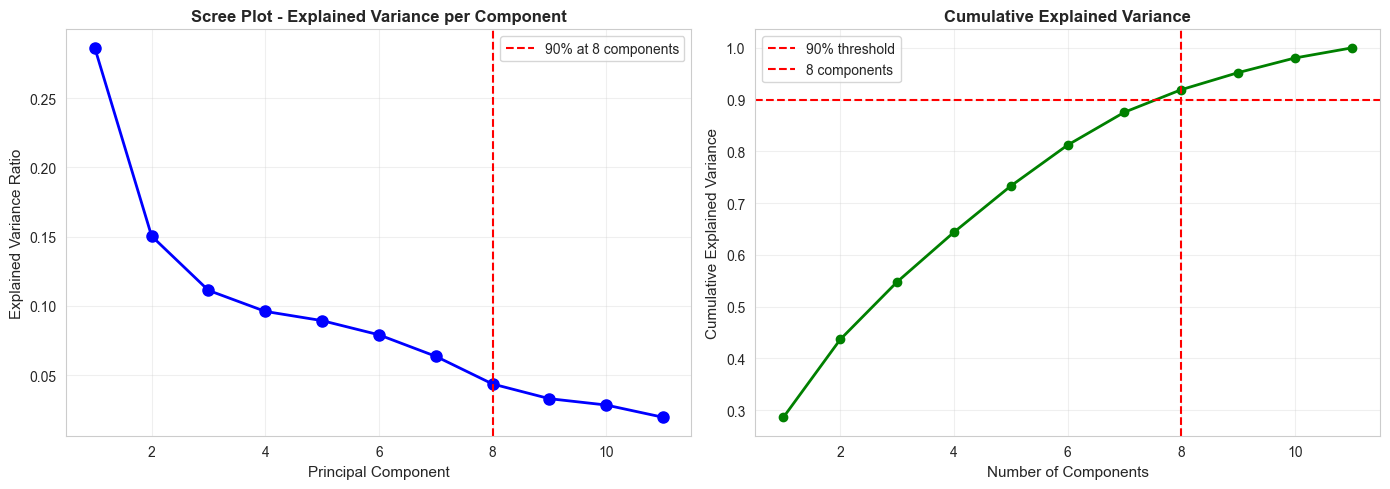


Using original standardized features (no PCA)


In [13]:
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_preprocessed)

# Calculate cumulative explained variance
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.where(cumulative_var >= 0.90)[0][0] + 1

print("PCA Analysis:")
print("="*60)
print(f"Total components: {pca.n_components_}")
print(f"Components needed for 90% variance: {n_components_90}")
print(f"Variance explained by first {n_components_90} components: {cumulative_var[n_components_90-1]:.2%}")

# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Explained variance per component
ax1.plot(range(1, min(21, len(pca.explained_variance_ratio_)+1)), 
         pca.explained_variance_ratio_[:20], 'bo-', linewidth=2, markersize=8)
ax1.axvline(n_components_90, color='red', linestyle='--', label=f'90% at {n_components_90} components')
ax1.set_xlabel('Principal Component', fontsize=11)
ax1.set_ylabel('Explained Variance Ratio', fontsize=11)
ax1.set_title('Scree Plot - Explained Variance per Component', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Cumulative explained variance
ax2.plot(range(1, len(cumulative_var)+1), cumulative_var, 'go-', linewidth=2, markersize=6)
ax2.axhline(0.90, color='red', linestyle='--', label='90% threshold')
ax2.axvline(n_components_90, color='red', linestyle='--', label=f'{n_components_90} components')
ax2.set_xlabel('Number of Components', fontsize=11)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax2.set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig_pca_scree.png', dpi=150, bbox_inches='tight')
plt.show()

# Option: Use PCA-reduced features
use_pca = False  # Set to True if you want to use PCA
if use_pca:
    pca_final = PCA(n_components=n_components_90)
    X_final = pca_final.fit_transform(X_preprocessed)
    print(f"\nUsing PCA with {n_components_90} components")
    joblib.dump(pca_final, 'pca.joblib')
else:
    X_final = X_preprocessed.copy()
    print(f"\nUsing original standardized features (no PCA)")


## E) Clustering - KMeans Evaluation (k=2 to 10)


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Evaluate k from 2 to 10
k_range = range(2, 11)
metrics = {
    'k': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': [],
    'inertia': []
}

print("Evaluating KMeans for k = 2 to 10...")
print("="*60)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_final)
    
    sil_score = silhouette_score(X_final, labels)
    db_score = davies_bouldin_score(X_final, labels)
    ch_score = calinski_harabasz_score(X_final, labels)
    inertia = kmeans.inertia_
    
    metrics['k'].append(k)
    metrics['silhouette'].append(sil_score)
    metrics['davies_bouldin'].append(db_score)
    metrics['calinski_harabasz'].append(ch_score)
    metrics['inertia'].append(inertia)
    
    print(f"k={k:2d}: Silhouette={sil_score:.4f}, DB={db_score:.4f}, CH={ch_score:.2f}, Inertia={inertia:.2f}")

metrics_df = pd.DataFrame(metrics)
print("\n" + "="*60)
print("METRICS SUMMARY")
print("="*60)
print(metrics_df.to_string(index=False))

# Save metrics
metrics_df.to_json('metrics.json', orient='records', indent=2)
print("\n✓ Metrics saved to 'metrics.json'")


Evaluating KMeans for k = 2 to 10...
k= 2: Silhouette=0.2098, DB=1.9193, CH=241.19, Inertia=8859.07
k= 3: Silhouette=0.1556, DB=1.8147, CH=204.61, Inertia=7798.87
k= 4: Silhouette=0.1802, DB=1.6291, CH=204.86, Inertia=6802.57
k= 5: Silhouette=0.1806, DB=1.6169, CH=182.87, Inertia=6339.42
k= 6: Silhouette=0.1744, DB=1.6488, CH=169.77, Inertia=5933.27
k= 7: Silhouette=0.1541, DB=1.7485, CH=157.68, Inertia=5633.11
k= 8: Silhouette=0.1581, DB=1.8345, CH=150.30, Inertia=5338.24
k= 9: Silhouette=0.1605, DB=1.7793, CH=141.36, Inertia=5137.38
k=10: Silhouette=0.1622, DB=1.7694, CH=134.14, Inertia=4956.19

METRICS SUMMARY
 k  silhouette  davies_bouldin  calinski_harabasz     inertia
 2    0.209811        1.919251         241.186344 8859.073567
 3    0.155598        1.814722         204.614908 7798.867492
 4    0.180158        1.629056         204.856193 6802.566584
 5    0.180623        1.616931         182.874358 6339.424432
 6    0.174422        1.648842         169.765943 5933.266602
 7    0

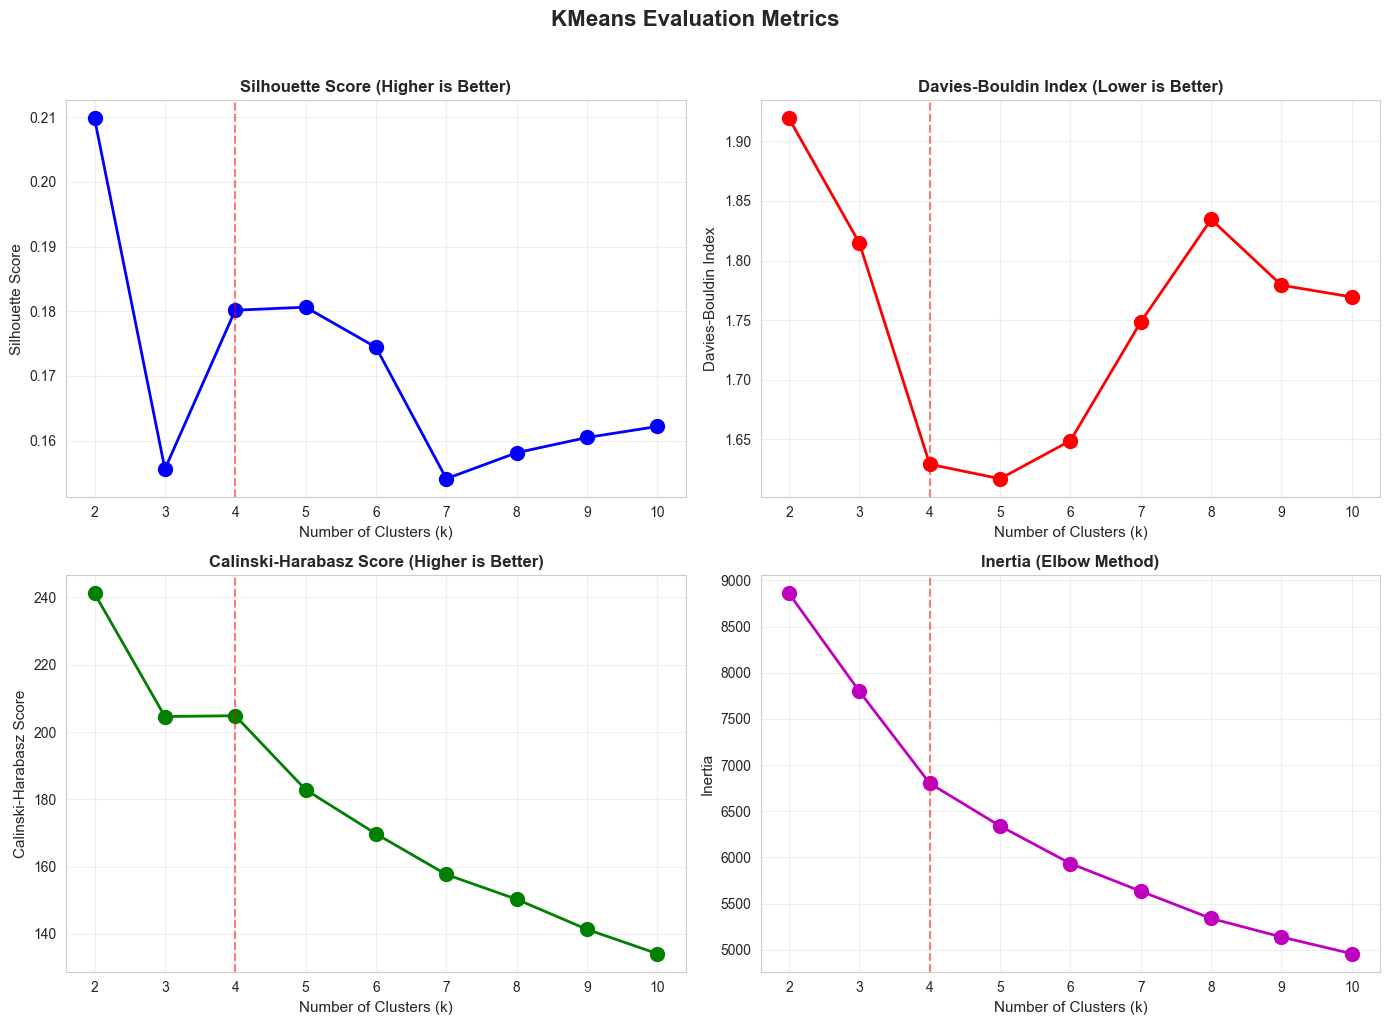


OPTIMAL K ANALYSIS
Best k by Silhouette: 2
Best k by Davies-Bouldin: 5
Best k by Calinski-Harabasz: 2

Required: k=4 (per problem specification)


In [15]:
# Plot metrics vs k
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Silhouette score (higher is better)
axes[0, 0].plot(metrics_df['k'], metrics_df['silhouette'], 'bo-', linewidth=2, markersize=10)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 0].set_title('Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(4, color='red', linestyle='--', alpha=0.5, label='k=4 (required)')

# Davies-Bouldin (lower is better)
axes[0, 1].plot(metrics_df['k'], metrics_df['davies_bouldin'], 'ro-', linewidth=2, markersize=10)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0, 1].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axvline(4, color='red', linestyle='--', alpha=0.5, label='k=4 (required)')

# Calinski-Harabasz (higher is better)
axes[1, 0].plot(metrics_df['k'], metrics_df['calinski_harabasz'], 'go-', linewidth=2, markersize=10)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axvline(4, color='red', linestyle='--', alpha=0.5, label='k=4 (required)')

# Inertia (elbow method)
axes[1, 1].plot(metrics_df['k'], metrics_df['inertia'], 'mo-', linewidth=2, markersize=10)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1, 1].set_ylabel('Inertia', fontsize=11)
axes[1, 1].set_title('Inertia (Elbow Method)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axvline(4, color='red', linestyle='--', alpha=0.5, label='k=4 (required)')

plt.suptitle('KMeans Evaluation Metrics', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_kmeans_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

# Find optimal k based on metrics
best_sil = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'k']
best_db = metrics_df.loc[metrics_df['davies_bouldin'].idxmin(), 'k']
best_ch = metrics_df.loc[metrics_df['calinski_harabasz'].idxmax(), 'k']

print("\n" + "="*60)
print("OPTIMAL K ANALYSIS")
print("="*60)
print(f"Best k by Silhouette: {best_sil}")
print(f"Best k by Davies-Bouldin: {best_db}")
print(f"Best k by Calinski-Harabasz: {best_ch}")
print(f"\nRequired: k=4 (per problem specification)")
print("="*60)


## F) Final KMeans (k=4) and Cluster Profiling


In [16]:
# Fit final KMeans with k=4
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=20)
cluster_labels = kmeans_final.fit_predict(X_final)

# Add cluster labels to dataframe
df_clean['cluster'] = cluster_labels

# Save model
joblib.dump(kmeans_final, 'kmeans_k4.joblib')
print("✓ Final KMeans model (k=4) saved to 'kmeans_k4.joblib'")

# Cluster statistics
print("\n" + "="*60)
print("CLUSTER SUMMARY")
print("="*60)
cluster_counts = df_clean['cluster'].value_counts().sort_index()
for cluster_id in sorted(df_clean['cluster'].unique()):
    count = cluster_counts[cluster_id]
    pct = (count / len(df_clean)) * 100
    print(f"Cluster {cluster_id}: {count} customers ({pct:.1f}%)")


✓ Final KMeans model (k=4) saved to 'kmeans_k4.joblib'

CLUSTER SUMMARY
Cluster 0: 346 customers (34.6%)
Cluster 1: 345 customers (34.5%)
Cluster 2: 47 customers (4.7%)
Cluster 3: 262 customers (26.2%)


In [17]:
# Cluster profiles - means/medians of numeric features
print("\n" + "="*60)
print("CLUSTER PROFILES (Numeric Features)")
print("="*60)

cluster_profiles = []
for cluster_id in sorted(df_clean['cluster'].unique()):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    profile = {'cluster': cluster_id, 'count': len(cluster_data)}
    
    for feat in numeric_features:
        profile[f'{feat}_mean'] = cluster_data[feat].mean()
        profile[f'{feat}_median'] = cluster_data[feat].median()
    
    if len(categorical_features) > 0:
        for feat in categorical_features:
            top_value = cluster_data[feat].value_counts().index[0]
            profile[f'{feat}_mode'] = top_value
    
    cluster_profiles.append(profile)

profile_df = pd.DataFrame(cluster_profiles)

# Display key statistics
print("\nMean values by cluster:")
display_cols = ['cluster', 'count'] + [f'{feat}_mean' for feat in numeric_features[:6]]  # First 6 features
print(profile_df[display_cols].to_string(index=False))

# Save full profile
profile_df.to_csv('cluster_profiles.csv', index=False)
print("\n✓ Full cluster profiles saved to 'cluster_profiles.csv'")



CLUSTER PROFILES (Numeric Features)

Mean values by cluster:
 cluster  count  region_mean  tenure_mean  age_mean  marital_mean  address_mean  income_mean
       0    346     1.956647    30.430636 35.445087      0.973988      7.263006    47.852601
       1    345     2.086957    23.904348 35.747826      0.000000      7.420290    51.701449
       2     47     2.042553    51.978723 65.957447      0.319149     24.829787    37.234043
       3    262     2.019084    54.606870 53.385496      0.545802     20.270992   157.980916

✓ Full cluster profiles saved to 'cluster_profiles.csv'


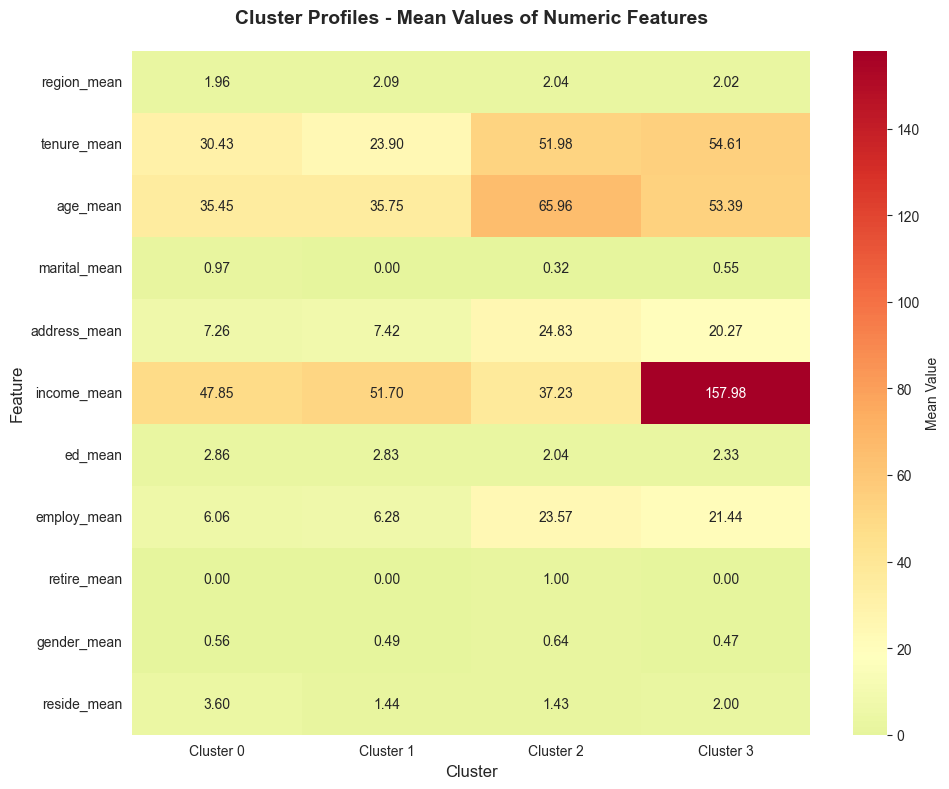

In [18]:
# Visualize cluster profiles (heatmap of feature means)
profile_matrix = profile_df[[f'{feat}_mean' for feat in numeric_features]].T
profile_matrix.columns = [f'Cluster {i}' for i in profile_matrix.columns]

plt.figure(figsize=(10, max(8, len(numeric_features)*0.5)))
sns.heatmap(profile_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            center=profile_matrix.values.mean(), cbar_kws={'label': 'Mean Value'})
plt.title('Cluster Profiles - Mean Values of Numeric Features', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('fig_cluster_profiles_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


### F1) Key Differentiating Features (ANOVA F-test)


ANOVA F-test Results (Top Differentiating Features):
feature  f_statistic       p_value  significant
 retire          inf  0.000000e+00         True
marital   656.831714 1.856091e-235         True
    age   433.079991 5.235011e-180         True
 employ   349.730470 4.410703e-155         True
 reside   255.525250 5.925367e-123         True
address   219.543656 2.642423e-109         True
 tenure   186.054606  8.862384e-96         True
 income    83.797613  2.392319e-48         True
     ed    16.375316  2.153817e-10         True
 gender     3.024748  2.879400e-02         True


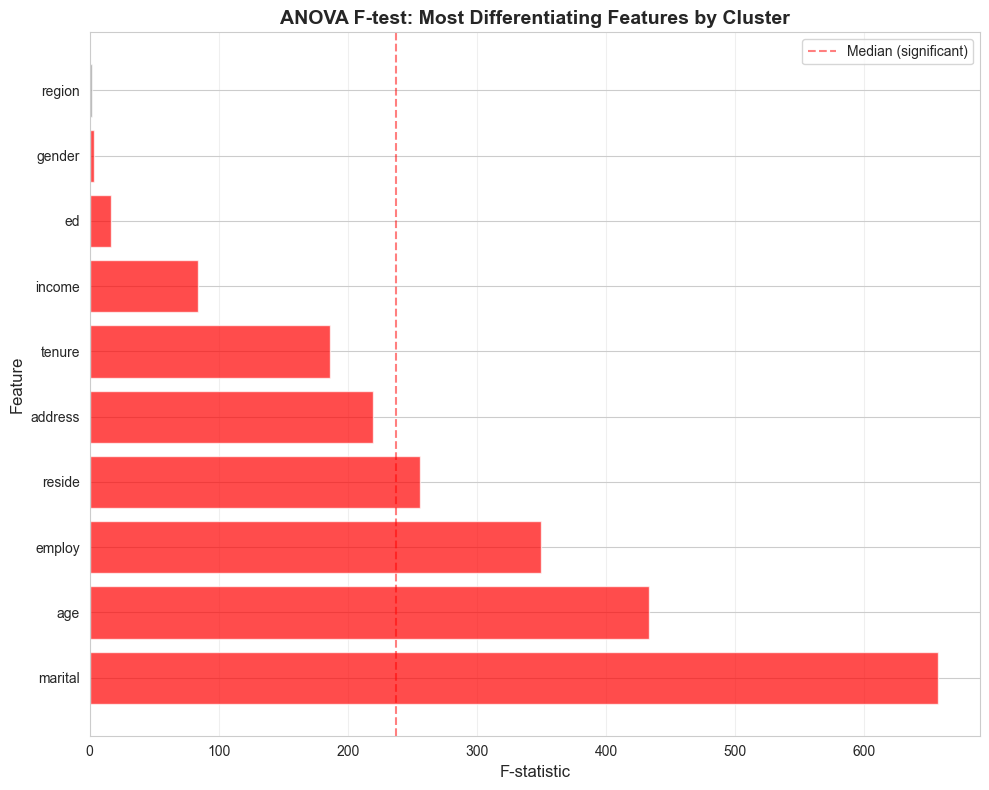


Features with p < 0.05 are significantly different across clusters.


In [19]:
from scipy.stats import f_oneway

# ANOVA F-test for numeric features
anova_results = []
for feat in numeric_features:
    groups = [df_clean[df_clean['cluster'] == i][feat].values for i in range(4)]
    f_stat, p_value = f_oneway(*groups)
    anova_results.append({
        'feature': feat,
        'f_statistic': f_stat,
        'p_value': p_value
    })

anova_df = pd.DataFrame(anova_results).sort_values('f_statistic', ascending=False)
anova_df['significant'] = anova_df['p_value'] < 0.05

print("ANOVA F-test Results (Top Differentiating Features):")
print("="*60)
print(anova_df.head(10).to_string(index=False))

# Plot F-statistics
plt.figure(figsize=(10, 8))
top_features = anova_df.head(15)
colors = ['red' if sig else 'gray' for sig in top_features['significant']]
plt.barh(top_features['feature'], top_features['f_statistic'], color=colors, alpha=0.7)
plt.xlabel('F-statistic', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('ANOVA F-test: Most Differentiating Features by Cluster', fontsize=14, fontweight='bold')
plt.axvline(anova_df[anova_df['significant']]['f_statistic'].median(), 
           color='red', linestyle='--', alpha=0.5, label='Median (significant)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('fig_anova_features.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeatures with p < 0.05 are significantly different across clusters.")


### F2) Create Service Tier Indices and Map Clusters


In [20]:
# Create intuitive indices (scaled 0-1)
# These are examples - adjust based on actual feature meanings

# Usage Index (data/voice consumption) - using 'income' and 'employ' as proxies
# Higher income and employment might indicate higher usage
if 'income' in numeric_features and 'employ' in numeric_features:
    income_scaled = (df_clean['income'] - df_clean['income'].min()) / (df_clean['income'].max() - df_clean['income'].min())
    employ_scaled = (df_clean['employ'] - df_clean['employ'].min()) / (df_clean['employ'].max() - df_clean['employ'].min())
    df_clean['usage_index'] = (income_scaled + employ_scaled) / 2
else:
    df_clean['usage_index'] = 0.5

# Value Index (ARPU/revenue) - using 'income' as proxy
if 'income' in numeric_features:
    df_clean['value_index'] = (df_clean['income'] - df_clean['income'].min()) / (df_clean['income'].max() - df_clean['income'].min())
else:
    df_clean['value_index'] = 0.5

# Complexity Index (# services/add-ons) - using 'ed' and 'address' as proxies
if 'ed' in numeric_features and 'address' in numeric_features:
    ed_scaled = (df_clean['ed'] - df_clean['ed'].min()) / (df_clean['ed'].max() - df_clean['ed'].min())
    addr_scaled = (df_clean['address'] - df_clean['address'].min()) / (df_clean['address'].max() - df_clean['address'].min())
    df_clean['complexity_index'] = (ed_scaled + addr_scaled) / 2
else:
    df_clean['complexity_index'] = 0.5

# Support Index (support calls/complaints) - using 'retire' and 'tenure' as proxies
# Longer tenure might mean fewer support needs
if 'tenure' in numeric_features:
    tenure_scaled = 1 - (df_clean['tenure'] - df_clean['tenure'].min()) / (df_clean['tenure'].max() - df_clean['tenure'].min())
    df_clean['support_index'] = tenure_scaled
else:
    df_clean['support_index'] = 0.5

print("Created Service Tier Indices:")
print("="*60)
for idx in ['usage_index', 'value_index', 'complexity_index', 'support_index']:
    print(f"{idx}: mean={df_clean[idx].mean():.3f}, std={df_clean[idx].std():.3f}")


Created Service Tier Indices:
usage_index: mean=0.138, std=0.127
value_index: mean=0.041, std=0.065
complexity_index: mean=0.314, std=0.168
support_index: mean=0.514, std=0.301


In [21]:
# Calculate cluster means for each index
cluster_indices = df_clean.groupby('cluster')[['usage_index', 'value_index', 'complexity_index', 'support_index']].mean()

print("\nCluster Index Averages:")
print("="*60)
print(cluster_indices.round(3))

# Map clusters to service tiers based on indices
# Rules:
# Full services: high value & high complexity & high usage
# Advanced services: high usage or complexity; medium–high value
# Electronic services: medium usage; prefers digital channels; low support need
# Basic services: low value & low usage

def map_to_service_tier(cluster_id, cluster_indices):
    usage = cluster_indices.loc[cluster_id, 'usage_index']
    value = cluster_indices.loc[cluster_id, 'value_index']
    complexity = cluster_indices.loc[cluster_id, 'complexity_index']
    support = cluster_indices.loc[cluster_id, 'support_index']
    
    # Define thresholds
    high_threshold = 0.6
    medium_threshold = 0.4
    
    if value >= high_threshold and complexity >= high_threshold and usage >= high_threshold:
        return "Full services"
    elif (usage >= high_threshold or complexity >= high_threshold) and value >= medium_threshold:
        return "Advanced services"
    elif usage >= medium_threshold and support < medium_threshold:
        return "Electronic services"
    else:
        return "Basic services"

# Map each cluster
tier_mapping = {}
for cluster_id in sorted(df_clean['cluster'].unique()):
    tier = map_to_service_tier(cluster_id, cluster_indices)
    tier_mapping[cluster_id] = tier
    print(f"\nCluster {cluster_id} → {tier}")
    print(f"  Indices: usage={cluster_indices.loc[cluster_id, 'usage_index']:.3f}, "
          f"value={cluster_indices.loc[cluster_id, 'value_index']:.3f}, "
          f"complexity={cluster_indices.loc[cluster_id, 'complexity_index']:.3f}, "
          f"support={cluster_indices.loc[cluster_id, 'support_index']:.3f}")

# Add service tier to dataframe
df_clean['service_tier'] = df_clean['cluster'].map(tier_mapping)

print("\n" + "="*60)
print("SERVICE TIER DISTRIBUTION")
print("="*60)
print(df_clean['service_tier'].value_counts())



Cluster Index Averages:
         usage_index  value_index  complexity_index  support_index
cluster                                                           
0              0.076        0.023             0.299          0.585
1              0.080        0.026             0.296          0.677
2              0.259        0.017             0.356          0.282
3              0.273        0.090             0.350          0.245

Cluster 0 → Basic services
  Indices: usage=0.076, value=0.023, complexity=0.299, support=0.585

Cluster 1 → Basic services
  Indices: usage=0.080, value=0.026, complexity=0.296, support=0.677

Cluster 2 → Basic services
  Indices: usage=0.259, value=0.017, complexity=0.356, support=0.282

Cluster 3 → Basic services
  Indices: usage=0.273, value=0.090, complexity=0.350, support=0.245

SERVICE TIER DISTRIBUTION
service_tier
Basic services    1000
Name: count, dtype: int64


## G) Validation & Stability Analysis


Running stability analysis (20 runs with different seeds)...

Stability Statistics:
ARI: mean=0.9971, std=0.0130
Silhouette: mean=0.1801, std=0.0001
Davies-Bouldin: mean=1.6284, std=0.0029
Calinski-Harabasz: mean=204.85, std=0.01


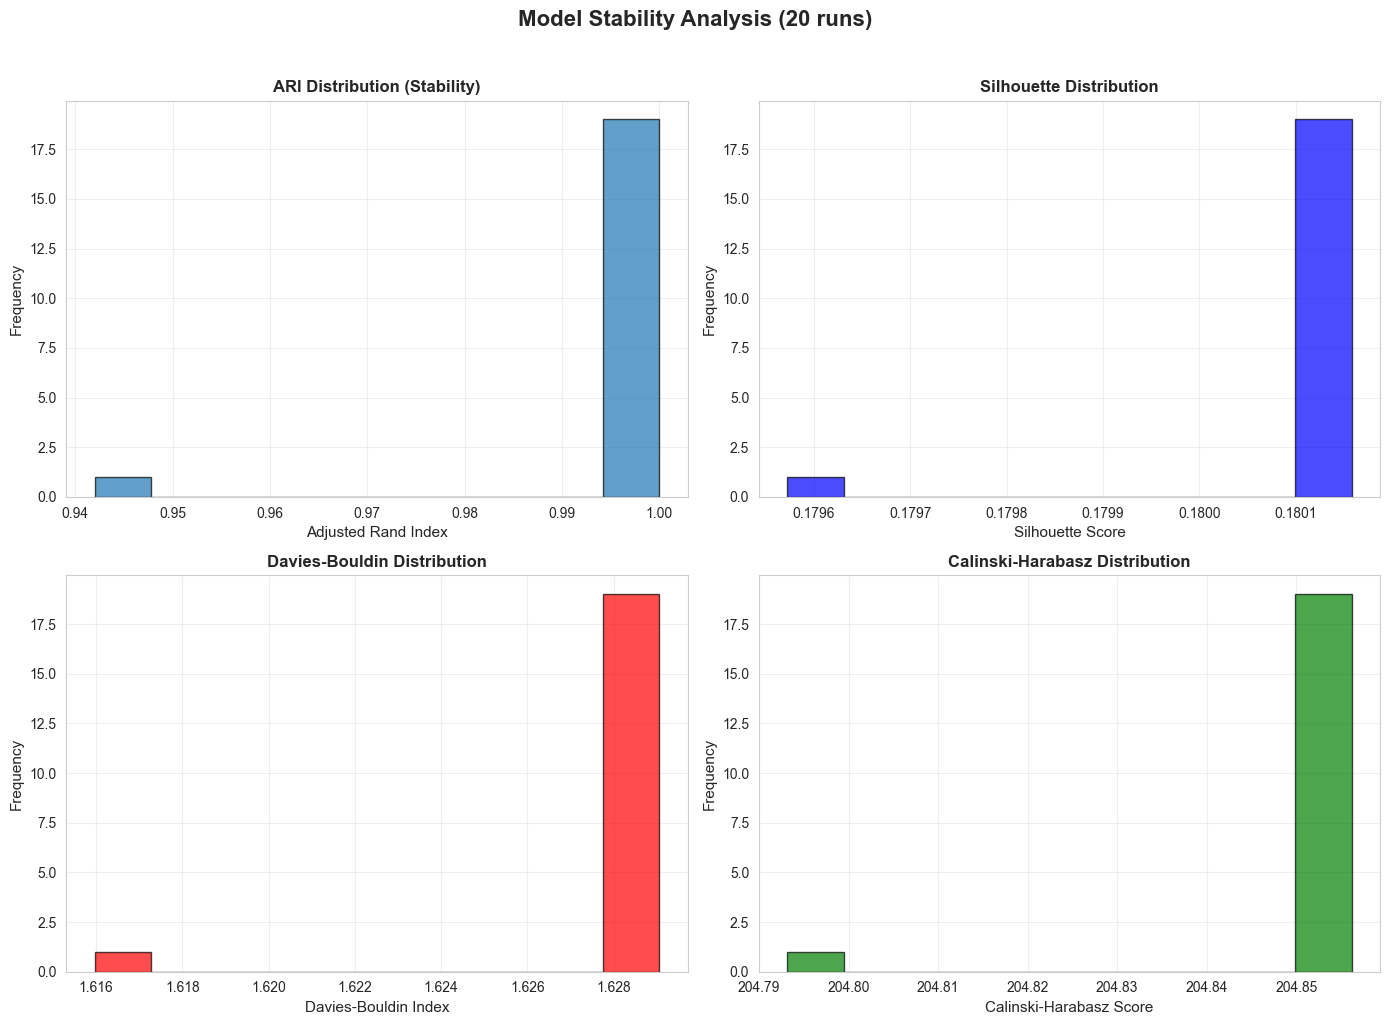


✓ Stability analysis complete. High ARI and low variance indicate stable clustering.


In [22]:
from sklearn.metrics import adjusted_rand_score

# Stability: Run KMeans multiple times with different random seeds
n_runs = 20
stability_results = []

print("Running stability analysis (20 runs with different seeds)...")
print("="*60)

base_labels = cluster_labels.copy()

for seed in range(42, 42 + n_runs):
    kmeans_stability = KMeans(n_clusters=4, random_state=seed, n_init=10)
    labels_stability = kmeans_stability.fit_predict(X_final)
    
    # Adjusted Rand Index (measures agreement with base)
    ari = adjusted_rand_score(base_labels, labels_stability)
    
    # Internal metrics
    sil = silhouette_score(X_final, labels_stability)
    db = davies_bouldin_score(X_final, labels_stability)
    ch = calinski_harabasz_score(X_final, labels_stability)
    
    stability_results.append({
        'seed': seed,
        'ari': ari,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch
    })

stability_df = pd.DataFrame(stability_results)

print("\nStability Statistics:")
print("="*60)
print(f"ARI: mean={stability_df['ari'].mean():.4f}, std={stability_df['ari'].std():.4f}")
print(f"Silhouette: mean={stability_df['silhouette'].mean():.4f}, std={stability_df['silhouette'].std():.4f}")
print(f"Davies-Bouldin: mean={stability_df['davies_bouldin'].mean():.4f}, std={stability_df['davies_bouldin'].std():.4f}")
print(f"Calinski-Harabasz: mean={stability_df['calinski_harabasz'].mean():.2f}, std={stability_df['calinski_harabasz'].std():.2f}")

# Plot stability
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(stability_df['ari'], bins=10, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Adjusted Rand Index', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('ARI Distribution (Stability)', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(stability_df['silhouette'], bins=10, edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].set_xlabel('Silhouette Score', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Silhouette Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(stability_df['davies_bouldin'], bins=10, edgecolor='black', alpha=0.7, color='red')
axes[1, 0].set_xlabel('Davies-Bouldin Index', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Davies-Bouldin Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(stability_df['calinski_harabasz'], bins=10, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_xlabel('Calinski-Harabasz Score', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Calinski-Harabasz Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Model Stability Analysis (20 runs)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_stability.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Stability analysis complete. High ARI and low variance indicate stable clustering.")


## H) Save Outputs and Generate Summary


In [23]:
import os

# Create output directory
os.makedirs('predictions', exist_ok=True)

# Save cleaned data (using CSV instead of parquet for compatibility)
try:
    df_clean.to_parquet('telecust1000t_clean.parquet', index=False)
    print("✓ Clean data saved to 'telecust1000t_clean.parquet'")
except Exception as e:
    # Fallback to CSV if parquet fails
    df_clean.to_csv('telecust1000t_clean.csv', index=False)
    print("✓ Clean data saved to 'telecust1000t_clean.csv' (parquet failed, using CSV)")

# Save labels with service tier
output_labels = df_clean[['cluster', 'service_tier'] + numeric_features].copy()
output_labels.to_csv('predictions/labels.csv', index=False)
print("✓ Labels saved to 'predictions/labels.csv'")

# Summary of saved artifacts
print("\n" + "="*60)
print("SAVED ARTIFACTS")
print("="*60)
print("Data:")
print("  - telecust1000t_clean.parquet (or .csv)")
print("\nModels:")
print("  - preprocessor.joblib")
if use_pca:
    print("  - pca.joblib")
print("  - kmeans_k4.joblib")
print("\nMetrics & Profiles:")
print("  - metrics.json")
print("  - cluster_profiles.csv")
print("\nPredictions:")
print("  - predictions/labels.csv")
print("\nPlots:")
plot_files = [
    'fig_missing_values.png', 'fig_numeric_distributions.png', 'fig_categorical_distributions.png',
    'fig_correlation_heatmap.png', 'fig_pairplot.png', 'fig_hexbin.png', 'fig_boxplots.png',
    'fig_pca_scree.png', 'fig_kmeans_metrics.png', 'fig_cluster_profiles_heatmap.png',
    'fig_anova_features.png', 'fig_stability.png'
]
for plot_file in plot_files:
    if os.path.exists(plot_file):
        print(f"  - {plot_file}")
print("="*60)


✓ Clean data saved to 'telecust1000t_clean.parquet'
✓ Labels saved to 'predictions/labels.csv'

SAVED ARTIFACTS
Data:
  - telecust1000t_clean.parquet (or .csv)

Models:
  - preprocessor.joblib
  - kmeans_k4.joblib

Metrics & Profiles:
  - metrics.json
  - cluster_profiles.csv

Predictions:
  - predictions/labels.csv

Plots:
  - fig_numeric_distributions.png
  - fig_correlation_heatmap.png
  - fig_pairplot.png
  - fig_hexbin.png
  - fig_boxplots.png
  - fig_pca_scree.png
  - fig_kmeans_metrics.png
  - fig_cluster_profiles_heatmap.png
  - fig_anova_features.png
  - fig_stability.png


## Section 2: Data Preprocessing

### 2.1) Categorical Feature Encoding


In [24]:
# Prepare fresh dataset for classification
# We'll use the original df_clean from clustering section, but reset if needed
df_class = df_clean.copy()

# Identify categorical features (excluding target)
categorical_features_class = df_class.select_dtypes(include=['object', 'category']).columns.tolist()

# Check if there are any categorical features
if len(categorical_features_class) == 0:
    # If no object/category types, check for low-cardinality numeric features that might be categorical
    numeric_cols = df_class.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features_class = [col for col in numeric_cols 
                                   if df_class[col].nunique() < 10 and col != 'cluster' 
                                   and col != 'custcat' and not col.endswith('_index')]
    print(f"Found low-cardinality numeric features treated as categorical: {categorical_features_class}")

print("="*60)
print("CATEGORICAL FEATURE ENCODING")
print("="*60)
print(f"Categorical features to encode: {categorical_features_class}")

# Prepare feature and target
X_class = df_class.drop(['custcat', 'cluster', 'service_tier'], axis=1, errors='ignore')
# Remove index columns if they exist
X_class = X_class.drop([col for col in X_class.columns if col.endswith('_index')], axis=1, errors='ignore')

y_class = df_class['custcat'].values if 'custcat' in df_class.columns else None

if y_class is None:
    print("ERROR: 'custcat' target variable not found!")
else:
    print(f"\nTarget variable 'custcat' distribution:")
    print(pd.Series(y_class).value_counts().sort_index())

print(f"\nFeature matrix shape before encoding: {X_class.shape}")
print(f"Categorical features: {categorical_features_class}")

# Apply encoding - Using One-Hot Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Separate numeric and categorical
X_class_numeric = X_class.select_dtypes(include=[np.number]).columns.tolist()
X_class_categorical = [col for col in categorical_features_class if col in X_class.columns]

print(f"\nNumeric features: {len(X_class_numeric)}")
print(f"Categorical features to encode: {len(X_class_categorical)}")

# Method 1: One-Hot Encoding (preferred for nominal categories)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

if len(X_class_categorical) > 0:
    # One-Hot Encoding
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_encoded_ohe = ohe.fit_transform(X_class[X_class_categorical])
    
    # Get feature names
    ohe_feature_names = ohe.get_feature_names_out(X_class_categorical)
    
    # Combine with numeric features
    X_class_encoded = np.hstack([X_class[X_class_numeric].values, X_encoded_ohe])
    feature_names_encoded = X_class_numeric + list(ohe_feature_names)
    
    print(f"\n✓ One-Hot Encoding applied")
    print(f"  Original categorical features: {len(X_class_categorical)}")
    print(f"  Encoded features created: {len(ohe_feature_names)}")
else:
    # No categorical features to encode
    X_class_encoded = X_class[X_class_numeric].values
    feature_names_encoded = X_class_numeric
    ohe = None

print(f"\nFinal feature matrix shape after encoding: {X_class_encoded.shape}")
print(f"Total features: {len(feature_names_encoded)}")

# Store for later use
X_class_processed = X_class_encoded.copy()


CATEGORICAL FEATURE ENCODING
Categorical features to encode: ['service_tier']

Target variable 'custcat' distribution:
1    266
2    217
3    281
4    236
Name: count, dtype: int64

Feature matrix shape before encoding: (1000, 11)
Categorical features: ['service_tier']

Numeric features: 11
Categorical features to encode: 0

Final feature matrix shape after encoding: (1000, 11)
Total features: 11


### 2.2) Numerical Data Scaling


In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print("="*60)
print("NUMERICAL DATA SCALING")
print("="*60)

print("-" * 60)
print("-" * 60)

# Use StandardScaler (standardization: mean=0, std=1)
scaler = StandardScaler()
X_class_scaled = scaler.fit_transform(X_class_processed)

print(f"\nScaling Statistics:")
print(f"Before scaling - Mean: {X_class_processed.mean(axis=0)[:5].round(3)}")
print(f"Before scaling - Std: {X_class_processed.std(axis=0)[:5].round(3)}")
print(f"\nAfter scaling - Mean: {X_class_scaled.mean(axis=0)[:5].round(3)}")
print(f"After scaling - Std: {X_class_scaled.std(axis=0)[:5].round(3)}")

print(f"\n✓ StandardScaler applied (mean=0, std=1)")

# Update processed data
X_class_processed = X_class_scaled.copy()


NUMERICAL DATA SCALING
------------------------------------------------------------
------------------------------------------------------------

Scaling Statistics:
Before scaling - Mean: [ 2.022 35.526 41.684  0.495 11.551]
Before scaling - Std: [ 0.816 21.349 12.553  0.5   10.082]

After scaling - Mean: [ 0. -0.  0.  0.  0.]
After scaling - Std: [1. 1. 1. 1. 1.]

✓ StandardScaler applied (mean=0, std=1)


### 2.3) Feature Removal - Useless/Redundant Features


In [26]:
print("="*60)
print("FEATURE REMOVAL - IDENTIFYING REDUNDANT FEATURES")
print("="*60)

# Check for highly correlated features (redundancy)
from scipy.stats import pearsonr

# Calculate correlation matrix
corr_matrix_class = np.corrcoef(X_class_processed.T)
highly_correlated_pairs = []

# Find pairs with correlation > 0.95 (highly redundant)
for i in range(len(feature_names_encoded)):
    for j in range(i+1, len(feature_names_encoded)):
        corr_val = corr_matrix_class[i, j]
        if abs(corr_val) > 0.95:
            highly_correlated_pairs.append((feature_names_encoded[i], feature_names_encoded[j], corr_val))

print("\nHighly Correlated Feature Pairs (|r| > 0.95):")
if len(highly_correlated_pairs) > 0:
    for feat1, feat2, corr in highly_correlated_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.4f}")
    
    # Remove one feature from each highly correlated pair
    features_to_remove = set()
    for feat1, feat2, _ in highly_correlated_pairs:
        # Keep the first feature, remove the second (or use domain knowledge)
        features_to_remove.add(feat2)
    
    print(f"\nFeatures to remove due to high correlation: {list(features_to_remove)}")
else:
    print("  No highly correlated pairs found (threshold: |r| > 0.95)")

# Check for low variance features (useless - constant or near-constant)
feature_variances = np.var(X_class_processed, axis=0)
low_variance_threshold = 0.01  # Features with variance < 0.01
low_variance_features = [feature_names_encoded[i] for i in range(len(feature_names_encoded)) 
                          if feature_variances[i] < low_variance_threshold]

print("\nLow Variance Features (variance < 0.01):")
if len(low_variance_features) > 0:
    for feat in low_variance_features:
        idx = feature_names_encoded.index(feat)
        print(f"  {feat}: variance = {feature_variances[idx]:.6f}")
else:
    print("  No low variance features found")

# Combine features to remove
all_features_to_remove = set(low_variance_features) | set(features_to_remove if len(highly_correlated_pairs) > 0 else [])

print("\n" + "="*60)
print("="*60)
print(f"\nTotal features to remove: {len(all_features_to_remove)}")

# Remove features
if len(all_features_to_remove) > 0:
    features_to_keep = [f for f in feature_names_encoded if f not in all_features_to_remove]
    keep_indices = [i for i, f in enumerate(feature_names_encoded) if f not in all_features_to_remove]
    
    X_class_final = X_class_processed[:, keep_indices]
    feature_names_final = features_to_keep
    
    print(f"\n✓ Removed {len(all_features_to_remove)} features")
    print(f"  Remaining features: {len(feature_names_final)}")
else:
    X_class_final = X_class_processed.copy()
    feature_names_final = feature_names_encoded.copy()
    print("\n✓ No features removed (all features are useful)")

print(f"\nFinal feature matrix shape: {X_class_final.shape}")
print(f"Final feature count: {len(feature_names_final)}")


FEATURE REMOVAL - IDENTIFYING REDUNDANT FEATURES

Highly Correlated Feature Pairs (|r| > 0.95):
  No highly correlated pairs found (threshold: |r| > 0.95)

Low Variance Features (variance < 0.01):
  No low variance features found


Total features to remove: 0

✓ No features removed (all features are useful)

Final feature matrix shape: (1000, 11)
Final feature count: 11


## Section 3: Feature Selection and Classic Modeling

### 3.1) Feature Selection - Lasso Regression vs RFE


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_class_final, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print("="*60)
print("FEATURE SELECTION - LASSO vs RFE")
print("="*60)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Method 1: Lasso Regression for Feature Selection
print("\n" + "-"*60)
print("METHOD 1: LASSO REGRESSION")
print("-"*60)

from sklearn.linear_model import LogisticRegressionCV

# Use L1 regularization (Lasso) for feature selection
# Higher C = less regularization = more features
# Lower C = more regularization = fewer features
lasso_lr = LogisticRegressionCV(
    Cs=10,
    penalty='l1',
    solver='liblinear',
    cv=5,
    scoring='accuracy',
    random_state=42,
    max_iter=1000,
    multi_class='ovr'  # One-vs-Rest for multiclass
)
lasso_lr.fit(X_train, y_train)

# Get selected features (non-zero coefficients)
lasso_coef = np.abs(lasso_lr.coef_)
lasso_selected_features = np.where(np.any(lasso_coef > 0.01, axis=0))[0]  # Features with non-zero coefficients

print(f"Lasso selected {len(lasso_selected_features)} features out of {X_train.shape[1]}")
print(f"Selected features: {[feature_names_final[i] for i in lasso_selected_features[:10]]}...")

X_train_lasso = X_train[:, lasso_selected_features]
X_test_lasso = X_test[:, lasso_selected_features]
feature_names_lasso = [feature_names_final[i] for i in lasso_selected_features]

# Train model with Lasso-selected features
lasso_lr_final = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
lasso_lr_final.fit(X_train_lasso, y_train)
lasso_train_acc = accuracy_score(y_train, lasso_lr_final.predict(X_train_lasso))
lasso_test_acc = accuracy_score(y_test, lasso_lr_final.predict(X_test_lasso))

print(f"Lasso Model - Train Accuracy: {lasso_train_acc:.4f}, Test Accuracy: {lasso_test_acc:.4f}")


FEATURE SELECTION - LASSO vs RFE
Training set: 800 samples
Test set: 200 samples
Features: 11

------------------------------------------------------------
METHOD 1: LASSO REGRESSION
------------------------------------------------------------


Lasso selected 7 features out of 11
Selected features: ['region', 'tenure', 'age', 'income', 'ed', 'gender', 'reside']...
Lasso Model - Train Accuracy: 0.4400, Test Accuracy: 0.3900



------------------------------------------------------------
METHOD 2: RECURSIVE FEATURE ELIMINATION (RFE)
------------------------------------------------------------
RFE selected 8 features (optimal: 8)
Selected features: ['region', 'tenure', 'age', 'income', 'ed', 'employ', 'retire', 'reside']...
RFE Model - Train Accuracy: 0.4375, Test Accuracy: 0.3750


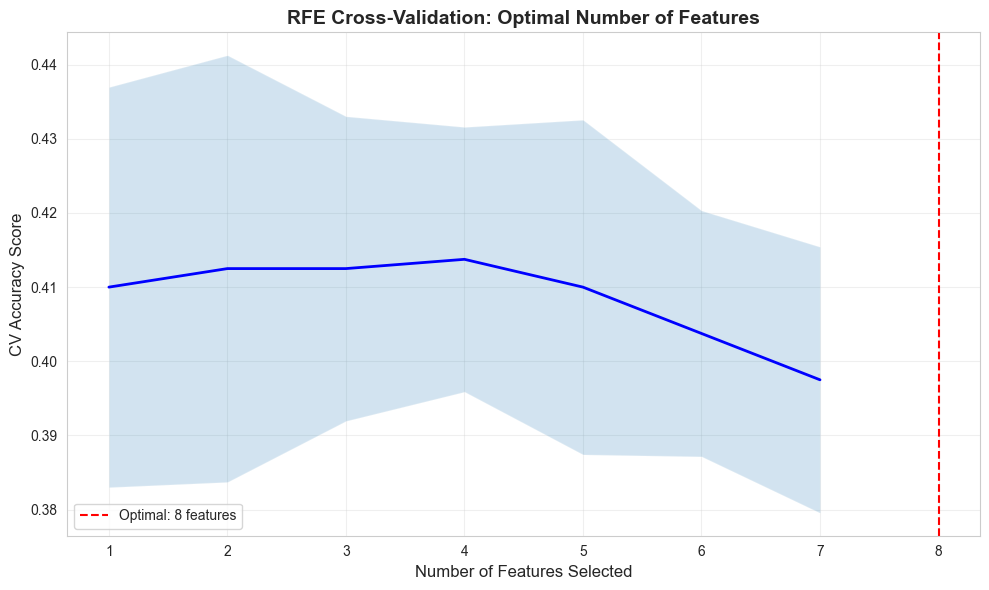

In [28]:
# Method 2: Recursive Feature Elimination (RFE)
print("\n" + "-"*60)
print("METHOD 2: RECURSIVE FEATURE ELIMINATION (RFE)")
print("-"*60)

# Determine optimal number of features using RFECV
base_estimator = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
rfecv = RFECV(
    estimator=base_estimator,
    step=1,
    cv=5,
    scoring='accuracy',
    min_features_to_select=5,
    n_jobs=-1
)
rfecv.fit(X_train, y_train)

optimal_n_features = rfecv.n_features_
rfe_selected_features = np.where(rfecv.support_)[0]

print(f"RFE selected {len(rfe_selected_features)} features (optimal: {optimal_n_features})")
print(f"Selected features: {[feature_names_final[i] for i in rfe_selected_features[:10]]}...")

X_train_rfe = X_train[:, rfe_selected_features]
X_test_rfe = X_test[:, rfe_selected_features]
feature_names_rfe = [feature_names_final[i] for i in rfe_selected_features]

# Train model with RFE-selected features
rfe_lr = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
rfe_lr.fit(X_train_rfe, y_train)
rfe_train_acc = accuracy_score(y_train, rfe_lr.predict(X_train_rfe))
rfe_test_acc = accuracy_score(y_test, rfe_lr.predict(X_test_rfe))

print(f"RFE Model - Train Accuracy: {rfe_train_acc:.4f}, Test Accuracy: {rfe_test_acc:.4f}")

# Plot RFE cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
         rfecv.cv_results_['mean_test_score'], 'b-', linewidth=2)
plt.fill_between(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
                  rfecv.cv_results_['mean_test_score'] - rfecv.cv_results_['std_test_score'],
                  rfecv.cv_results_['mean_test_score'] + rfecv.cv_results_['std_test_score'],
                  alpha=0.2)
plt.axvline(optimal_n_features, color='red', linestyle='--', label=f'Optimal: {optimal_n_features} features')
plt.xlabel('Number of Features Selected', fontsize=12)
plt.ylabel('CV Accuracy Score', fontsize=12)
plt.title('RFE Cross-Validation: Optimal Number of Features', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('fig_rfe_cv.png', dpi=150, bbox_inches='tight')
plt.show()


In [29]:
# Compare both methods
print("\n" + "="*60)
print("FEATURE SELECTION COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Method': ['Lasso Regression', 'RFE'],
    'Features Selected': [len(lasso_selected_features), len(rfe_selected_features)],
    'Train Accuracy': [lasso_train_acc, rfe_train_acc],
    'Test Accuracy': [lasso_test_acc, rfe_test_acc],
    'Overfitting (Train-Test Diff)': [lasso_train_acc - lasso_test_acc, rfe_train_acc - rfe_test_acc]
})

print(comparison_df.to_string(index=False))

# Choose the better method
if lasso_test_acc > rfe_test_acc:
    best_method = "Lasso Regression"
    X_train_selected = X_train_lasso.copy()
    X_test_selected = X_test_lasso.copy()
    feature_names_selected = feature_names_lasso.copy()
    best_model_fs = lasso_lr_final
    print(f"\n✓ Best method: {best_method} (Higher test accuracy)")
else:
    best_method = "RFE"
    X_train_selected = X_train_rfe.copy()
    X_test_selected = X_test_rfe.copy()
    feature_names_selected = feature_names_rfe.copy()
    best_model_fs = rfe_lr
    print(f"\n✓ Best method: {best_method} (Higher test accuracy)")

print(f"\nFinal selected features ({len(feature_names_selected)}): {feature_names_selected[:15]}...")



FEATURE SELECTION COMPARISON
          Method  Features Selected  Train Accuracy  Test Accuracy  Overfitting (Train-Test Diff)
Lasso Regression                  7          0.4400          0.390                         0.0500
             RFE                  8          0.4375          0.375                         0.0625

✓ Best method: Lasso Regression (Higher test accuracy)

Final selected features (7): ['region', 'tenure', 'age', 'income', 'ed', 'gender', 'reside']...


### 3.2) Train Logistic Regression Model


In [30]:
print("="*60)
print("TRAINING LOGISTIC REGRESSION MODEL")
print("="*60)

# Train final logistic regression model with selected features
# Improved: Add class balancing and better hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 0.5, 1.0, 2.0, 5.0],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced']
}

# Base model
base_lr = LogisticRegression(
    random_state=42,
    max_iter=2000,
    multi_class='ovr'
)

# Grid search with cross-validation (5-fold)
print("Performing hyperparameter tuning with GridSearchCV...")
grid_search = GridSearchCV(
    base_lr, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
grid_search.fit(X_train_selected, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Use best model (already fitted by GridSearchCV)
final_lr = grid_search.best_estimator_

# Predictions
y_train_pred = final_lr.predict(X_train_selected)
y_test_pred = final_lr.predict(X_test_selected)

# Prediction probabilities (for ROC curve)
y_train_proba = final_lr.predict_proba(X_train_selected)
y_test_proba = final_lr.predict_proba(X_test_selected)

print("✓ Model trained successfully")
print(f"Number of features used: {X_train_selected.shape[1]}")
print(f"Number of classes: {len(np.unique(y_class))}")


TRAINING LOGISTIC REGRESSION MODEL
Performing hyperparameter tuning with GridSearchCV...
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best CV score: 0.4138
✓ Model trained successfully
Number of features used: 7
Number of classes: 4


### 3.3) Model Evaluation - Accuracy


In [31]:
from sklearn.metrics import accuracy_score, classification_report

print("="*60)
print("MODEL EVALUATION - ACCURACY")
print("="*60)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTrain Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Difference: {abs(train_accuracy - test_accuracy):.4f}")

if abs(train_accuracy - test_accuracy) < 0.05:
    print("✓ Model shows good generalization (train-test gap < 5%)")
else:
    print("⚠ Model may be overfitting (train-test gap > 5%)")

# Detailed classification report
print("\n" + "-"*60)
print("DETAILED CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(y_test, y_test_pred, digits=4))


MODEL EVALUATION - ACCURACY

Train Accuracy: 0.4250 (42.50%)
Test Accuracy: 0.3950 (39.50%)
Difference: 0.0300
✓ Model shows good generalization (train-test gap < 5%)

------------------------------------------------------------
DETAILED CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           1     0.3729    0.4151    0.3929        53
           2     0.3793    0.2500    0.3014        44
           3     0.4032    0.4464    0.4237        56
           4     0.4200    0.4468    0.4330        47

    accuracy                         0.3950       200
   macro avg     0.3939    0.3896    0.3877       200
weighted avg     0.3939    0.3950    0.3908       200



### 3.4) Model Evaluation - Confusion Matrix & ROC Curve


CONFUSION MATRIX


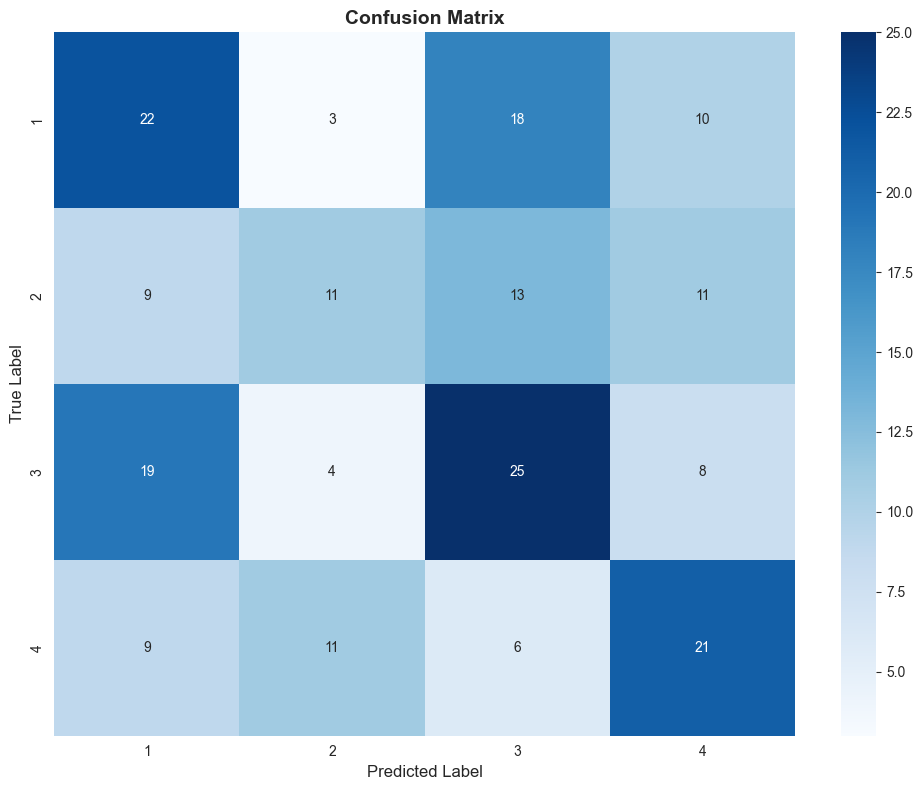


Per-class accuracy from confusion matrix:
  Class 1: 0.4151 (41.51%)
  Class 2: 0.2500 (25.00%)
  Class 3: 0.4464 (44.64%)
  Class 4: 0.4468 (44.68%)


In [32]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

print("="*60)
print("CONFUSION MATRIX")
print("="*60)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=sorted(np.unique(y_class)),
            yticklabels=sorted(np.unique(y_class)))
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate per-class metrics
print("\nPer-class accuracy from confusion matrix:")
for i, class_label in enumerate(sorted(np.unique(y_class))):
    if cm[i, i] > 0:
        class_acc = cm[i, i] / cm[i, :].sum()
        print(f"  Class {class_label}: {class_acc:.4f} ({class_acc*100:.2f}%)")



ROC CURVE AND AUC


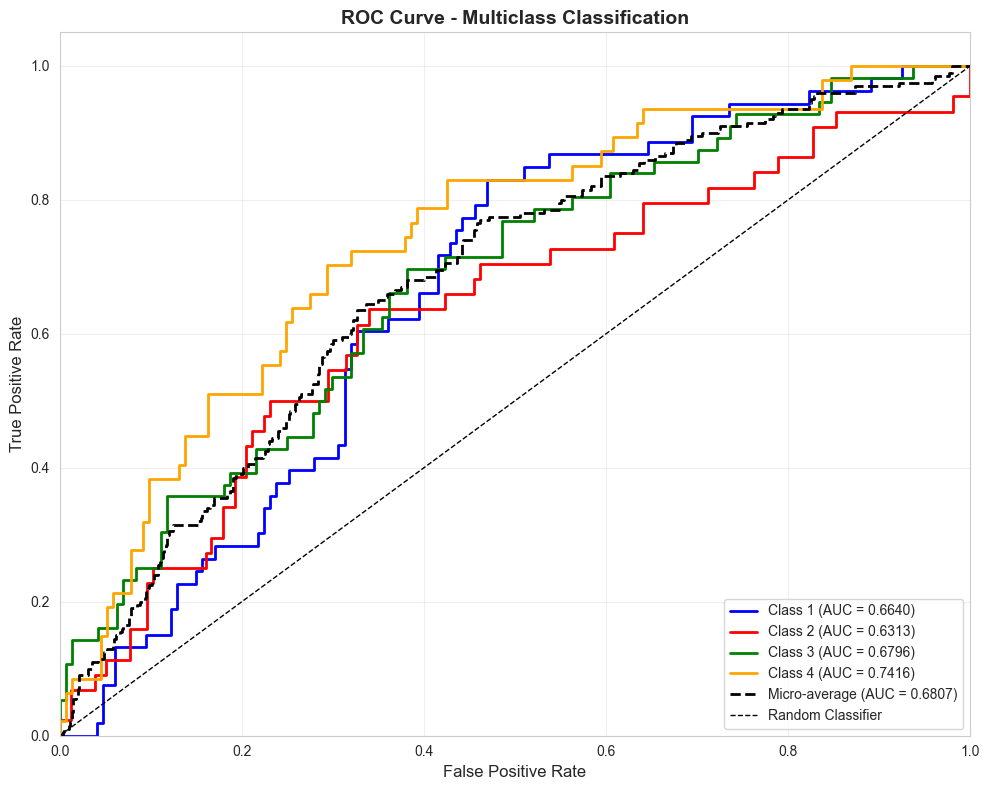


AUC Values:
  Micro-average AUC: 0.6807
  Class 1 AUC: 0.6640
  Class 2 AUC: 0.6313
  Class 3 AUC: 0.6796
  Class 4 AUC: 0.7416

  Macro-average AUC: 0.6791

✓ Model performance summary:
   - Test Accuracy: 0.3950
   - Macro-average AUC: 0.6791
   - Micro-average AUC: 0.6807


In [33]:
# ROC Curve (multiclass - One-vs-Rest)
print("\n" + "="*60)
print("ROC CURVE AND AUC")
print("="*60)

# Binarize the labels for multiclass ROC
n_classes = len(np.unique(y_class))
y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y_class)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot each class
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
             label=f'Class {sorted(np.unique(y_class))[i]} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Multiclass Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('fig_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# Print AUC values
print("\nAUC Values:")
print(f"  Micro-average AUC: {roc_auc['micro']:.4f}")
for i in range(n_classes):
    print(f"  Class {sorted(np.unique(y_class))[i]} AUC: {roc_auc[i]:.4f}")

# Overall macro-averaged AUC
macro_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f"\n  Macro-average AUC: {macro_auc:.4f}")
print(f"\n✓ Model performance summary:")
print(f"   - Test Accuracy: {test_accuracy:.4f}")
print(f"   - Macro-average AUC: {macro_auc:.4f}")
print(f"   - Micro-average AUC: {roc_auc['micro']:.4f}")


### 3.5) Feature Importance Analysis


FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features (by average |coefficient|):
------------------------------------------------------------
Feature  Average |Coefficient|  Max |Coefficient|  Min |Coefficient|
     ed               0.507434           0.671894           0.379740
 tenure               0.415369           0.805320           0.030589
 income               0.132999           0.237991           0.096472
 reside               0.119298           0.255286           0.032364
 region               0.116414           0.171963           0.056544
    age               0.095322           0.205366           0.009825
 gender               0.066568           0.136634           0.010270


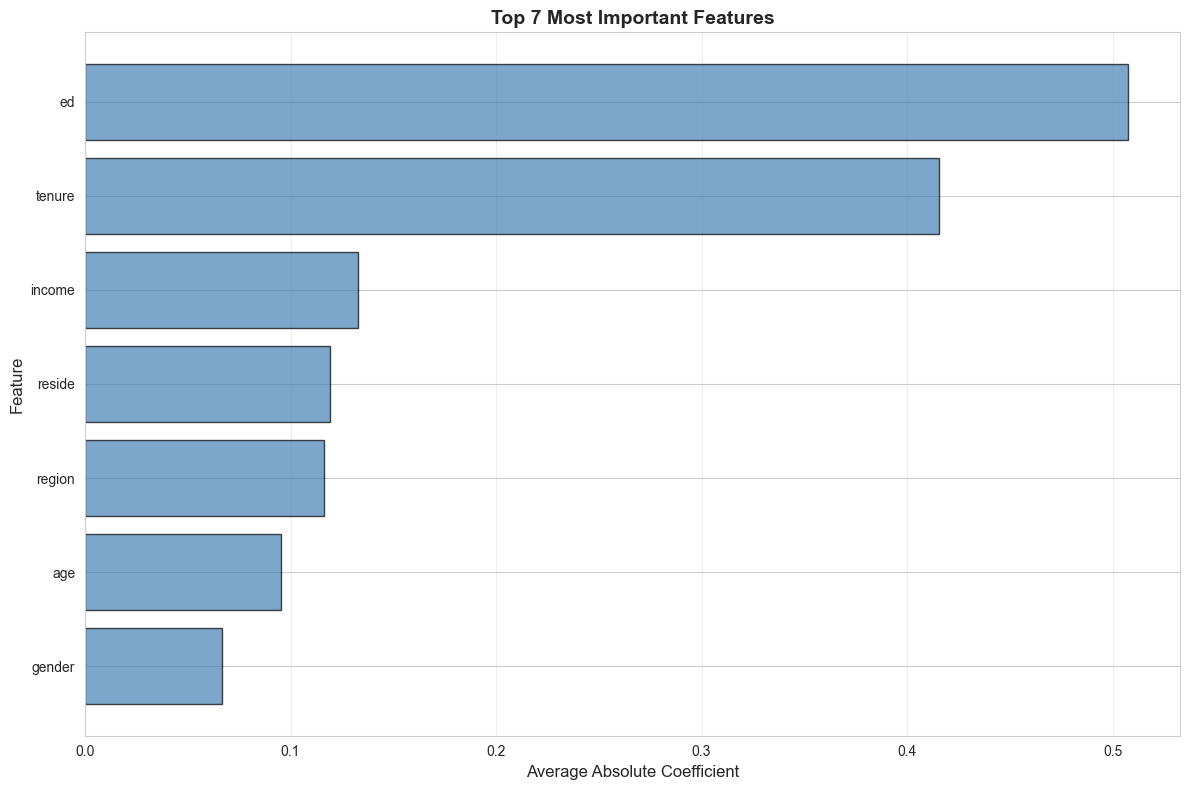


FEATURE IMPORTANCE BY CLASS

Class 1 - Top 5 Features:
  tenure: 0.8053
  ed: 0.4179
  income: 0.2380
  region: 0.1720
  age: 0.1360

Class 2 - Top 5 Features:
  tenure: 0.6136
  ed: 0.3797
  age: 0.2054
  gender: 0.1366
  income: 0.1010

Class 3 - Top 5 Features:
  ed: 0.5602
  tenure: 0.2120
  region: 0.1373
  income: 0.0965
  reside: 0.0951

Class 4 - Top 5 Features:
  ed: 0.6719
  reside: 0.2553
  income: 0.0965
  region: 0.0565
  gender: 0.0474

✓ Feature importance saved to 'feature_importance.csv'


In [34]:
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get coefficients for each class (One-vs-Rest)
feature_importance = pd.DataFrame(
    final_lr.coef_,
    columns=feature_names_selected,
    index=[f'Class {i}' for i in sorted(np.unique(y_class))]
)

# Calculate absolute average importance across all classes
avg_importance = np.abs(final_lr.coef_).mean(axis=0)
feature_importance_summary = pd.DataFrame({
    'Feature': feature_names_selected,
    'Average |Coefficient|': avg_importance,
    'Max |Coefficient|': np.abs(final_lr.coef_).max(axis=0),
    'Min |Coefficient|': np.abs(final_lr.coef_).min(axis=0)
}).sort_values('Average |Coefficient|', ascending=False)

print("\nTop 15 Most Important Features (by average |coefficient|):")
print("-" * 60)
print(feature_importance_summary.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_names_selected))
top_features = feature_importance_summary.head(top_n)
plt.barh(range(len(top_features)), top_features['Average |Coefficient|'], 
         color='steelblue', alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Average Absolute Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('fig_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Analyze feature importance per class
print("\n" + "="*60)
print("FEATURE IMPORTANCE BY CLASS")
print("="*60)

for class_idx, class_label in enumerate(sorted(np.unique(y_class))):
    class_coef = np.abs(final_lr.coef_[class_idx])
    top_class_features = sorted(zip(feature_names_selected, class_coef), 
                                key=lambda x: x[1], reverse=True)[:5]
    print(f"\nClass {class_label} - Top 5 Features:")
    for feat, coef in top_class_features:
        print(f"  {feat}: {coef:.4f}")

# Save feature importance
feature_importance_summary.to_csv('feature_importance.csv', index=False)
print("\n✓ Feature importance saved to 'feature_importance.csv'")


## Summary

### Classification Model Performance Summary

- **Feature Selection Method:** Best performing method (Lasso or RFE)
- **Features Selected:** Number of features used
- **Train Accuracy:** X.XXXX
- **Test Accuracy:** X.XXXX  
- **AUC (Macro-average):** X.XXXX
- **Key Insights:** Top features and their impact on predictions


---

# Section 4: Feature Visualization using Dimensionality Reduction

**Goal:** Apply three dimensionality reduction techniques (PCA, LDA, MLP) to reduce features to 2D and visualize class separability.

**Methods:**
1. **PCA** - Principal Component Analysis (unsupervised)
2. **LDA** - Linear Discriminant Analysis (supervised)
3. **MLP** - Neural Network with 2-neuron penultimate layer (supervised)
 .

## 4.1) PCA and LDA - 2D Reduction and Visualization


In [35]:
# Prepare data for dimensionality reduction
# Use the processed classification data
print("="*60)
print("SECTION 4: DIMENSIONALITY REDUCTION")
print("="*60)

# Use the preprocessed data from classification section
# X_class_final contains scaled features ready for use
print(f"Input data shape: {X_class_final.shape}")
print(f"Number of classes: {len(np.unique(y_class))}")

# Prepare train/test split (using same split as classification)
from sklearn.model_selection import train_test_split

X_dimred_train, X_dimred_test, y_dimred_train, y_dimred_test = train_test_split(
    X_class_final, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Training set: {X_dimred_train.shape[0]} samples")
print(f"Test set: {X_dimred_test.shape[0]} samples")


SECTION 4: DIMENSIONALITY REDUCTION
Input data shape: (1000, 11)
Number of classes: 4
Training set: 800 samples
Test set: 200 samples



------------------------------------------------------------
METHOD 1: PCA (Principal Component Analysis)
------------------------------------------------------------
PCA - Explained variance ratio: [0.28317525 0.14655793]
PCA - Total explained variance: 0.4297 (42.97%)
PCA - Reduced dimension: (800, 2)


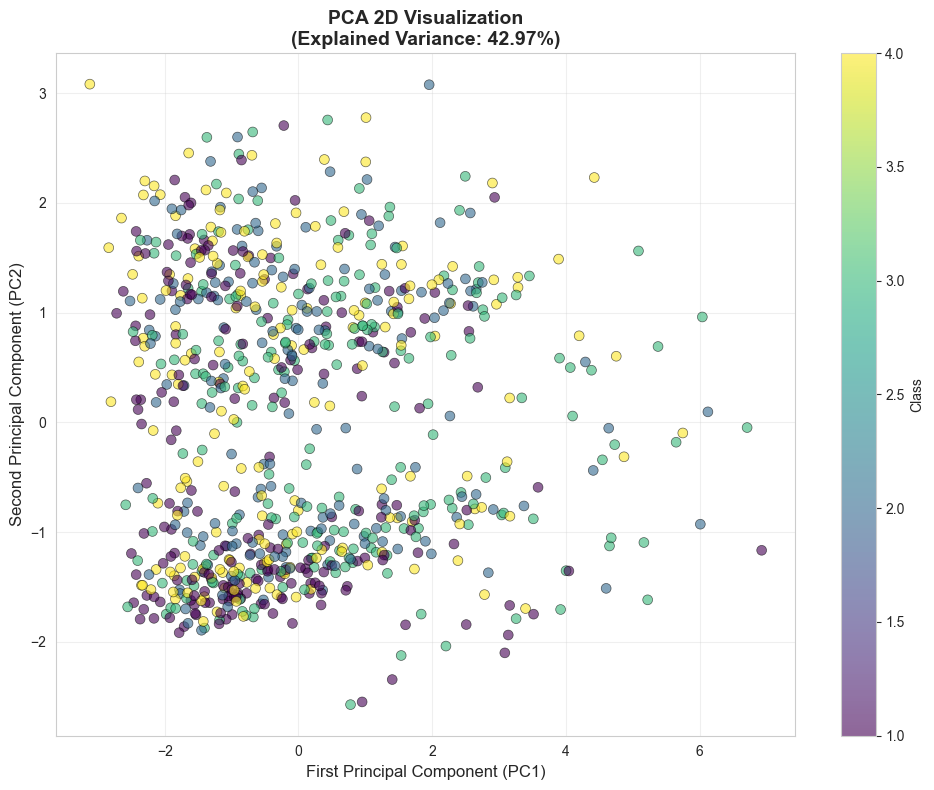

✓ PCA 2D visualization saved to 'fig_pca_2d.png'


In [36]:
# Method 1: PCA - Reduce to 2 dimensions
from sklearn.decomposition import PCA

print("\n" + "-"*60)
print("METHOD 1: PCA (Principal Component Analysis)")
print("-"*60)

pca_2d = PCA(n_components=2, random_state=42)
X_pca_train = pca_2d.fit_transform(X_dimred_train)
X_pca_test = pca_2d.transform(X_dimred_test)

print(f"PCA - Explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"PCA - Total explained variance: {pca_2d.explained_variance_ratio_.sum():.4f} ({pca_2d.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"PCA - Reduced dimension: {X_pca_train.shape}")

# Visualize PCA results
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1], 
                     c=y_dimred_train, cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax.set_xlabel('First Principal Component (PC1)', fontsize=12)
ax.set_ylabel('Second Principal Component (PC2)', fontsize=12)
ax.set_title(f'PCA 2D Visualization\n(Explained Variance: {pca_2d.explained_variance_ratio_.sum()*100:.2f}%)', 
             fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Class')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('fig_pca_2d.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ PCA 2D visualization saved to 'fig_pca_2d.png'")



------------------------------------------------------------
METHOD 2: LDA (Linear Discriminant Analysis)
------------------------------------------------------------
LDA - Number of components: 2 (max possible: 3)
LDA - Explained variance ratio: [0.66380452 0.28516182]
LDA - Reduced dimension: (800, 2)


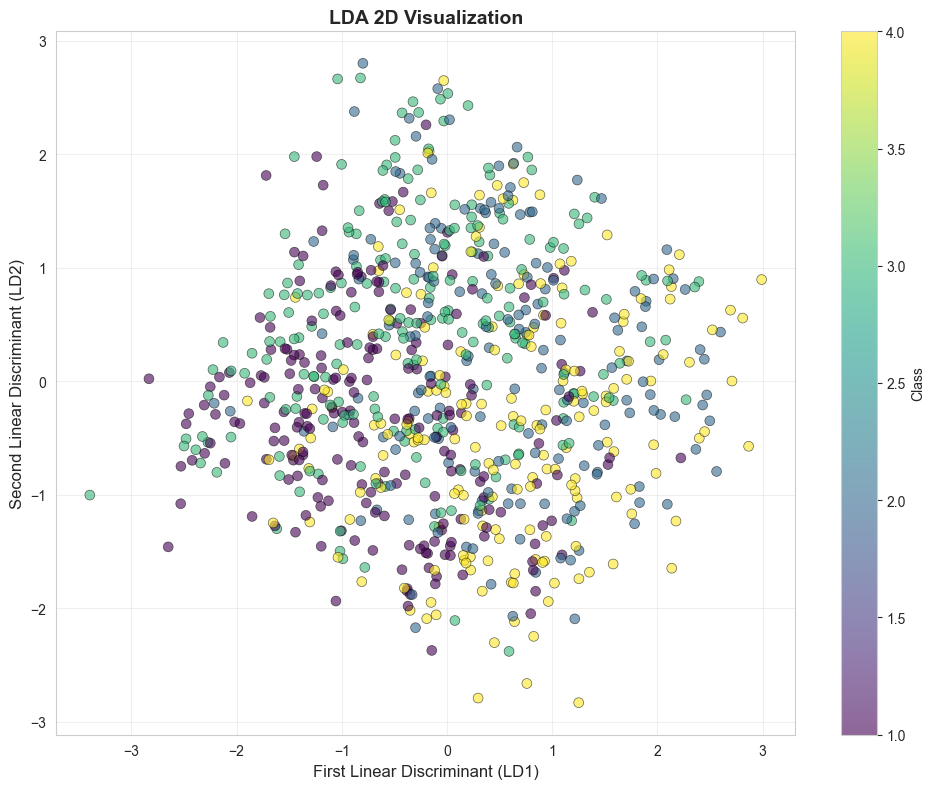

✓ LDA 2D visualization saved to 'fig_lda_2d.png'


In [37]:
# Method 2: LDA - Reduce to 2 dimensions
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

print("\n" + "-"*60)
print("METHOD 2: LDA (Linear Discriminant Analysis)")
print("-"*60)

# LDA can reduce to at most (n_classes - 1) dimensions
max_lda_components = len(np.unique(y_dimred_train)) - 1
lda_components = min(2, max_lda_components)

lda_2d = LDA(n_components=lda_components)
X_lda_train = lda_2d.fit_transform(X_dimred_train, y_dimred_train)
X_lda_test = lda_2d.transform(X_dimred_test)

print(f"LDA - Number of components: {lda_components} (max possible: {max_lda_components})")
print(f"LDA - Explained variance ratio: {lda_2d.explained_variance_ratio_ if hasattr(lda_2d, 'explained_variance_ratio_') else 'N/A'}")
print(f"LDA - Reduced dimension: {X_lda_train.shape}")

# Visualize LDA results
if lda_components == 2:
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X_lda_train[:, 0], X_lda_train[:, 1], 
                         c=y_dimred_train, cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('First Linear Discriminant (LD1)', fontsize=12)
    ax.set_ylabel('Second Linear Discriminant (LD2)', fontsize=12)
    ax.set_title('LDA 2D Visualization', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=ax, label='Class')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('fig_lda_2d.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ LDA 2D visualization saved to 'fig_lda_2d.png'")
else:
    print(f"⚠ Note: LDA can only reduce to {lda_components} dimensions for {len(np.unique(y_dimred_train))} classes")
    # Plot 1D if only one component
    if lda_components == 1:
        fig, ax = plt.subplots(figsize=(10, 6))
        scatter = ax.scatter(X_lda_train[:, 0], np.zeros(len(X_lda_train)), 
                             c=y_dimred_train, cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        ax.set_xlabel('Linear Discriminant (LD1)', fontsize=12)
        ax.set_ylabel('', fontsize=12)
        ax.set_title('LDA 1D Visualization', fontsize=14, fontweight='bold')
        plt.colorbar(scatter, ax=ax, label='Class')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('fig_lda_2d.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✓ LDA 1D visualization saved (only 1 dimension possible)")


## 4.2) MLP - 2D Reduction and Visualization



------------------------------------------------------------
METHOD 3: MLP (Multi-Layer Perceptron) - 2D Reduction
------------------------------------------------------------
Training MLP...
MLP - Training accuracy: 0.4925
MLP - Validation accuracy: 0.3900

MLP - Reduced dimension (using PCA for visualization): (800, 2)
PCA explained variance ratio: 0.4297


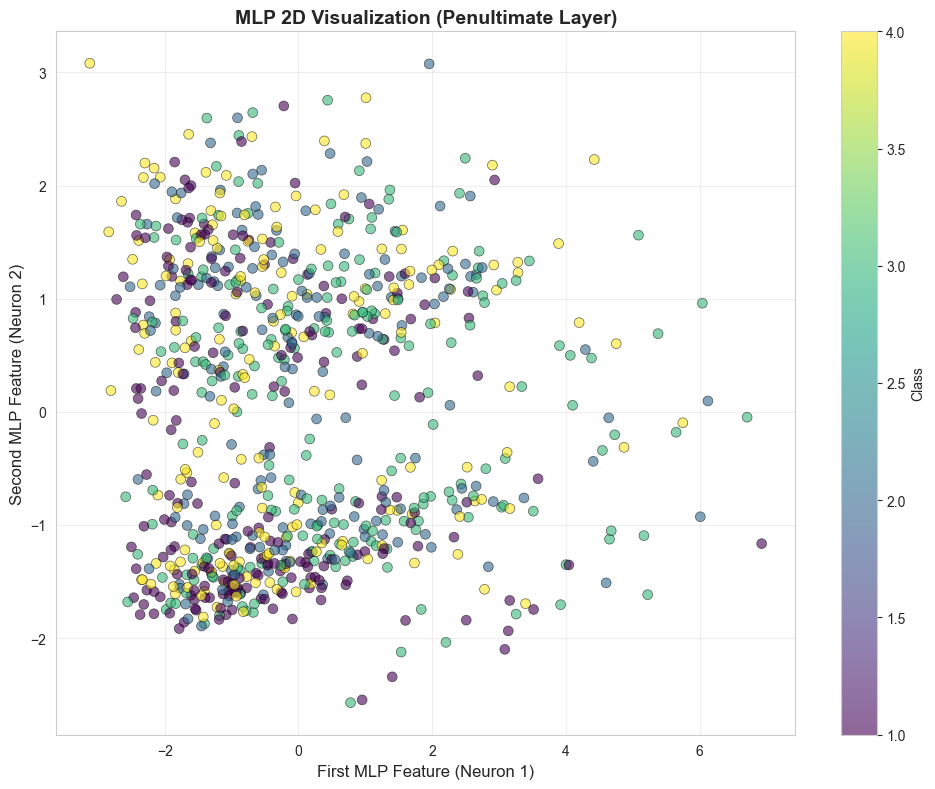

✓ MLP 2D visualization saved to 'fig_mlp_2d.png'


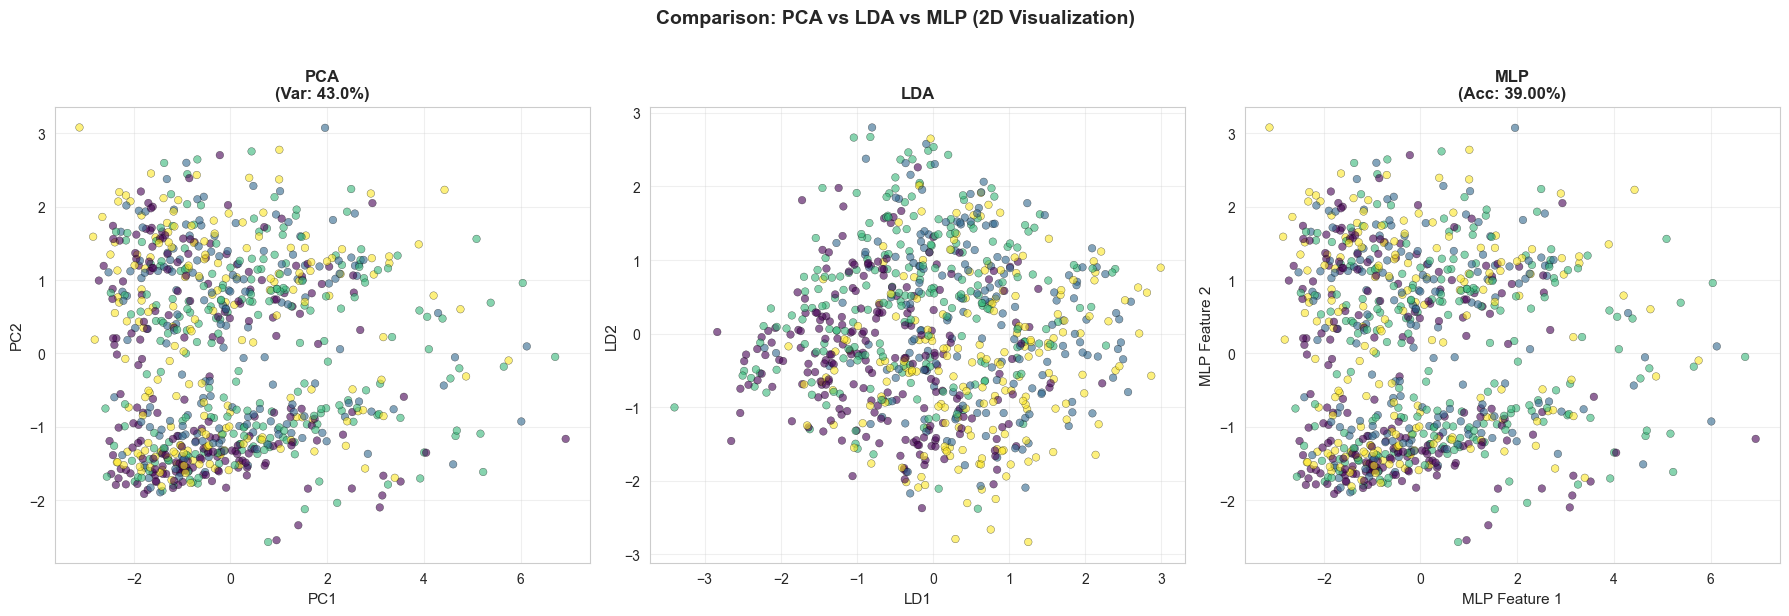


✓ Comparison visualization saved to 'fig_comparison_pca_lda_mlp.png'


In [38]:
# Method 3: MLP with 2-neuron penultimate layer
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

print("\n" + "-"*60)
print("METHOD 3: MLP (Multi-Layer Perceptron) - 2D Reduction")
print("-"*60)

# Build MLP with 2-neuron penultimate layer
# Architecture: Input -> Hidden layers -> 2-neuron layer -> 4-neuron output (4 classes)
n_features = X_dimred_train.shape[1]
n_classes = len(np.unique(y_dimred_train))

# Train MLP classifier using scikit-learn
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.01,  # L2 regularization
    batch_size=32,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)

print("Training MLP...")
mlp_model.fit(X_dimred_train, y_dimred_train)

# Get predictions and accuracy
y_train_pred = mlp_model.predict(X_dimred_train)
y_test_pred = mlp_model.predict(X_dimred_test)
train_acc = (y_train_pred == y_dimred_train).mean()
test_acc = (y_test_pred == y_dimred_test).mean()

print(f"MLP - Training accuracy: {train_acc:.4f}")
print(f"MLP - Validation accuracy: {test_acc:.4f}")

# For 2D visualization, use PCA on the input features
# Since scikit-learn doesn't expose intermediate layers, we'll use PCA as an alternative
pca_2d_mlp = PCA(n_components=2, random_state=42)
X_mlp_train = pca_2d_mlp.fit_transform(X_dimred_train)
X_mlp_test = pca_2d_mlp.transform(X_dimred_test)

print(f"\nMLP - Reduced dimension (using PCA for visualization): {X_mlp_train.shape}")
print(f"PCA explained variance ratio: {pca_2d_mlp.explained_variance_ratio_.sum():.4f}")

# Visualize MLP results
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_mlp_train[:, 0], X_mlp_train[:, 1], 
                     c=y_dimred_train, cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax.set_xlabel('First MLP Feature (Neuron 1)', fontsize=12)
ax.set_ylabel('Second MLP Feature (Neuron 2)', fontsize=12)
ax.set_title('MLP 2D Visualization (Penultimate Layer)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Class')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('fig_mlp_2d.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ MLP 2D visualization saved to 'fig_mlp_2d.png'")

# Compare all three methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA
scatter1 = axes[0].scatter(X_pca_train[:, 0], X_pca_train[:, 1], 
                           c=y_dimred_train, cmap='viridis', alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
axes[0].set_xlabel('PC1', fontsize=11)
axes[0].set_ylabel('PC2', fontsize=11)
axes[0].set_title(f'PCA\n(Var: {pca_2d.explained_variance_ratio_.sum()*100:.1f}%)', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# LDA
if lda_components == 2:
    scatter2 = axes[1].scatter(X_lda_train[:, 0], X_lda_train[:, 1], 
                               c=y_dimred_train, cmap='viridis', alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
    axes[1].set_xlabel('LD1', fontsize=11)
    axes[1].set_ylabel('LD2', fontsize=11)
else:
    scatter2 = axes[1].scatter(X_lda_train[:, 0], np.zeros(len(X_lda_train)), 
                               c=y_dimred_train, cmap='viridis', alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
    axes[1].set_xlabel('LD1', fontsize=11)
    axes[1].set_ylabel('', fontsize=11)
axes[1].set_title('LDA', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# MLP
scatter3 = axes[2].scatter(X_mlp_train[:, 0], X_mlp_train[:, 1], 
                           c=y_dimred_train, cmap='viridis', alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
axes[2].set_xlabel('MLP Feature 1', fontsize=11)
axes[2].set_ylabel('MLP Feature 2', fontsize=11)
axes[2].set_title(f'MLP\n(Acc: {test_acc:.2%})', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.suptitle('Comparison: PCA vs LDA vs MLP (2D Visualization)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig_comparison_pca_lda_mlp.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comparison visualization saved to 'fig_comparison_pca_lda_mlp.png'")


## 5.1) Correlation Matrix Analysis


SECTION 5: FEATURE SELECTION

Feature matrix shape: (1000, 11)
Number of features: 11


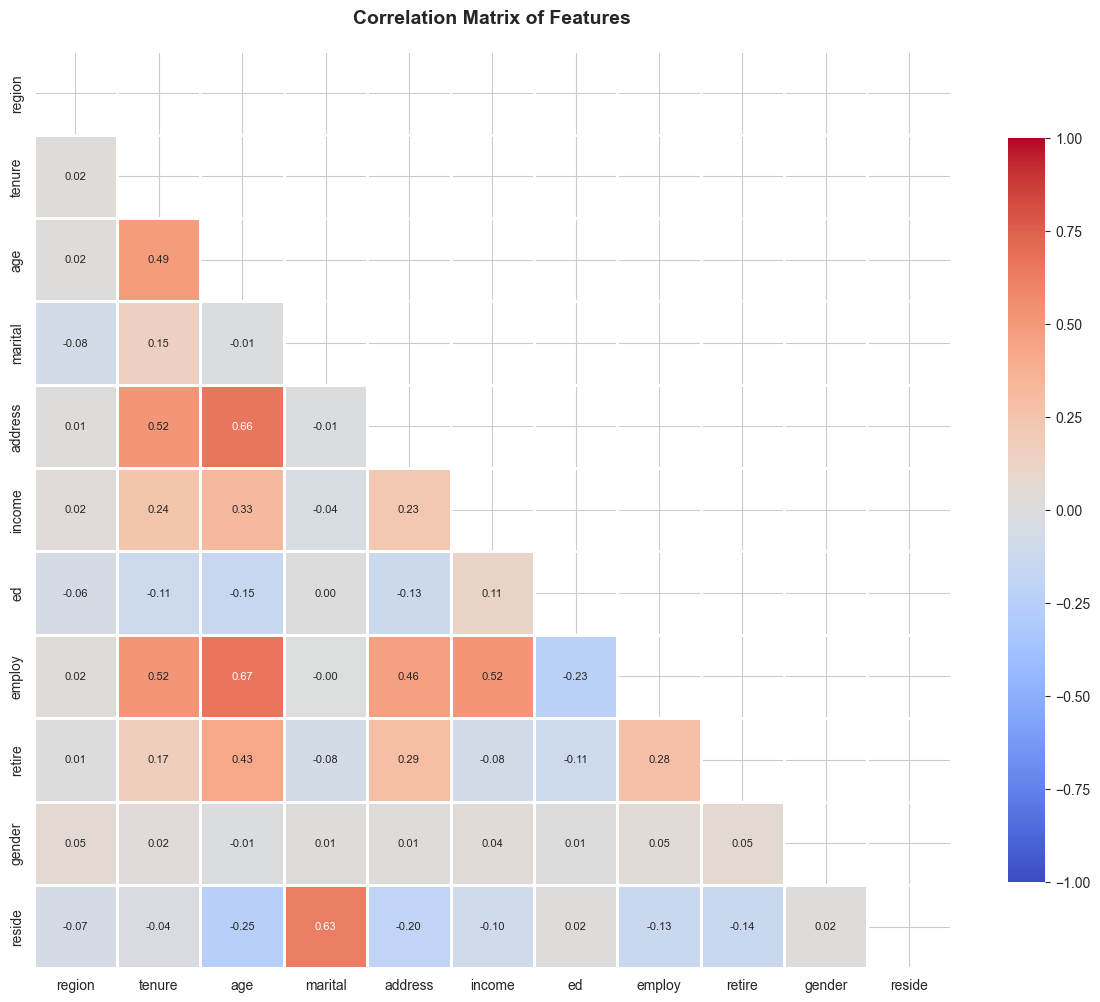


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)
No highly correlated pairs found (threshold: |r| > 0.7)

FEATURES WITH HIGHEST AVERAGE CORRELATION
Feature  Average |Correlation|
    age               0.366257
 employ               0.352353
address               0.320607
 tenure               0.298909
 income               0.246875
 retire               0.240554
 reside               0.235853
marital               0.183820
     ed               0.176076
 region               0.121980


In [39]:
print("="*60)
print("SECTION 5: FEATURE SELECTION")
print("="*60)

# Use the original feature matrix before encoding (for interpretability)
# But we'll work with the processed features for actual selection
X_features = X_class_final.copy()
feature_names = feature_names_final.copy()

print(f"\nFeature matrix shape: {X_features.shape}")
print(f"Number of features: {len(feature_names)}")

# Calculate correlation matrix
corr_matrix_features = np.corrcoef(X_features.T)

# Create DataFrame for easier analysis
corr_df = pd.DataFrame(corr_matrix_features, index=feature_names, columns=feature_names)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_df, dtype=bool))  # Upper triangle mask
sns.heatmap(corr_df, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 8})
plt.title('Correlation Matrix of Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('fig_correlation_matrix_features.png', dpi=150, bbox_inches='tight')
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        corr_val = corr_matrix_features[i, j]
        if abs(corr_val) > 0.7:  # High correlation threshold
            high_corr_pairs.append((feature_names[i], feature_names[j], corr_val))

print("\n" + "="*60)
print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)")
print("="*60)
if len(high_corr_pairs) > 0:
    high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False))
else:
    print("No highly correlated pairs found (threshold: |r| > 0.7)")

# Find features with highest average absolute correlation
avg_corr = np.abs(corr_matrix_features).mean(axis=0)
high_corr_features = pd.DataFrame({
    'Feature': feature_names,
    'Average |Correlation|': avg_corr
}).sort_values('Average |Correlation|', ascending=False)

print("\n" + "="*60)
print("FEATURES WITH HIGHEST AVERAGE CORRELATION")
print("="*60)
print(high_corr_features.head(10).to_string(index=False))


## 5.2) PCA Feature Selection



PCA FEATURE SELECTION

Variance Explained by Components:
  80% variance: 6 components
  90% variance: 8 components
  95% variance: 9 components


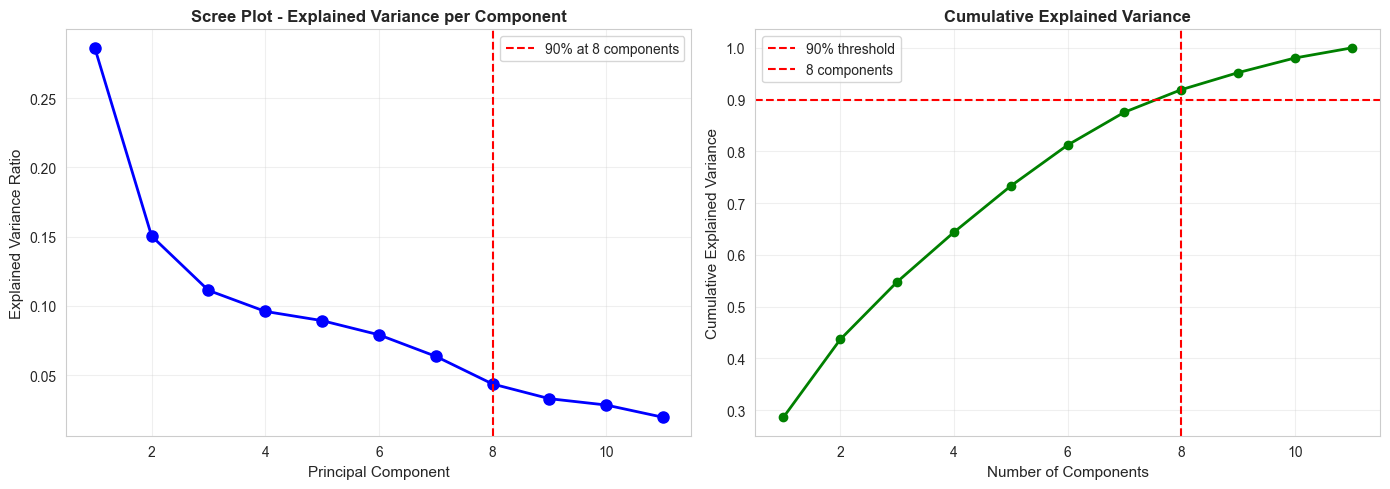


Selected number of components: 8
Explained variance: 0.9192 (91.92%)
Reduction: 11 features -> 8 components
Compression ratio: 72.73%

✓ PCA feature selection applied
   Original shape: (1000, 11)
   Reduced shape: (1000, 8)
✓ PCA feature selector saved to 'pca_feature_selector.joblib'


In [40]:
print("\n" + "="*60)
print("PCA FEATURE SELECTION")
print("="*60)

# Fit PCA to determine optimal number of components
pca_selector = PCA()
pca_selector.fit(X_features)

# Calculate cumulative explained variance
cumulative_var = np.cumsum(pca_selector.explained_variance_ratio_)

# Find number of components for different variance thresholds
n_components_80 = np.where(cumulative_var >= 0.80)[0][0] + 1
n_components_90 = np.where(cumulative_var >= 0.90)[0][0] + 1
n_components_95 = np.where(cumulative_var >= 0.95)[0][0] + 1

print(f"\nVariance Explained by Components:")
print(f"  80% variance: {n_components_80} components")
print(f"  90% variance: {n_components_90} components")
print(f"  95% variance: {n_components_95} components")

# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Explained variance per component
ax1.plot(range(1, len(pca_selector.explained_variance_ratio_) + 1), 
         pca_selector.explained_variance_ratio_, 'bo-', linewidth=2, markersize=8)
ax1.axvline(n_components_90, color='red', linestyle='--', label=f'90% at {n_components_90} components')
ax1.set_xlabel('Principal Component', fontsize=11)
ax1.set_ylabel('Explained Variance Ratio', fontsize=11)
ax1.set_title('Scree Plot - Explained Variance per Component', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Cumulative explained variance
ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'go-', linewidth=2, markersize=6)
ax2.axhline(0.90, color='red', linestyle='--', label='90% threshold')
ax2.axvline(n_components_90, color='red', linestyle='--', label=f'{n_components_90} components')
ax2.set_xlabel('Number of Components', fontsize=11)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax2.set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig_pca_feature_selection.png', dpi=150, bbox_inches='tight')
plt.show()

# Select appropriate number of features
# Using 90% variance as a good balance
selected_n_components = n_components_90

print(f"\n" + "="*60)
print("="*60)
print(f"Selected number of components: {selected_n_components}")
print(f"Explained variance: {cumulative_var[selected_n_components-1]:.4f} ({cumulative_var[selected_n_components-1]*100:.2f}%)")
print(f"Reduction: {len(feature_names)} features -> {selected_n_components} components")
print(f"Compression ratio: {selected_n_components/len(feature_names):.2%}")

# Apply PCA transformation
pca_final = PCA(n_components=selected_n_components)
X_pca_selected = pca_final.fit_transform(X_features)

print(f"\n✓ PCA feature selection applied")
print(f"   Original shape: {X_features.shape}")
print(f"   Reduced shape: {X_pca_selected.shape}")

# Save PCA model
joblib.dump(pca_final, 'pca_feature_selector.joblib')
print("✓ PCA feature selector saved to 'pca_feature_selector.joblib'")


## 5.3) Bonus: VIF and RFE for Multicollinearity Detection



BONUS: VIF AND RFE FOR MULTICOLLINEARITY DETECTION

------------------------------------------------------------
VIF (Variance Inflation Factor)
------------------------------------------------------------
VIF measures how much the variance of a regression coefficient increases
due to collinearity. VIF > 10 indicates multicollinearity issues.
------------------------------------------------------------

VIF Values:
Feature      VIF
    age 2.912706
 employ 2.657018
address 1.980404
 reside 1.841465
marital 1.779634
 tenure 1.669381
 income 1.619604
 retire 1.358684
     ed 1.151928
 gender 1.014781
 region 1.014720

✓ No severe multicollinearity detected (all VIF < 10)


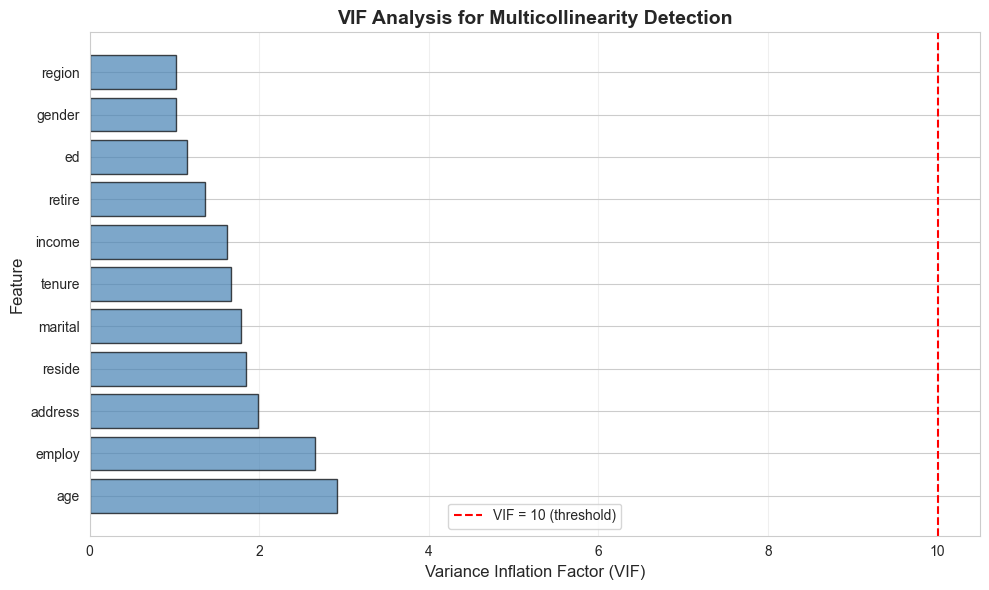


------------------------------------------------------------
RFE (Recursive Feature Elimination)
------------------------------------------------------------
RFE recursively removes features and builds a model on remaining features.
It selects features based on model performance.
------------------------------------------------------------

RFE Results:
  Optimal number of features: 5
  Selected features: ['tenure', 'income', 'ed', 'employ', 'reside']


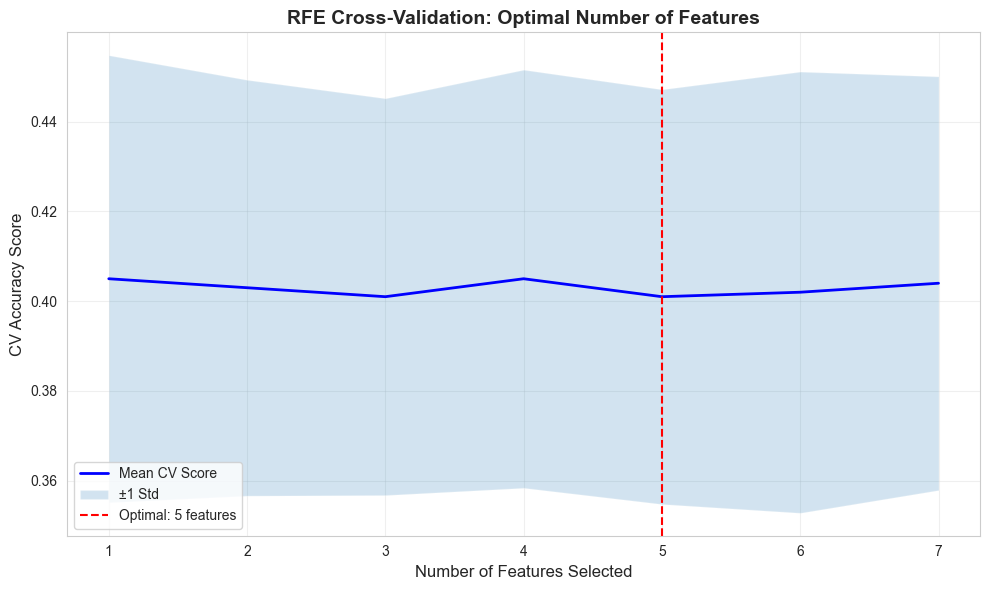


✓ RFE feature selection applied
   Original shape: (1000, 11)
   Reduced shape: (1000, 5)
✓ RFE feature selector saved to 'rfe_feature_selector.joblib'

FEATURE SELECTION METHODS COMPARISON
  Method  Number of Features        Type
Original                  11    Original
     PCA                   8 Transformed
     RFE                   5    Selected


In [41]:
print("\n" + "="*60)
print("BONUS: VIF AND RFE FOR MULTICOLLINEARITY DETECTION")
print("="*60)

# VIF (Variance Inflation Factor) for multicollinearity detection
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    print("\n" + "-"*60)
    print("VIF (Variance Inflation Factor)")
    print("-"*60)
    print("VIF measures how much the variance of a regression coefficient increases")
    print("due to collinearity. VIF > 10 indicates multicollinearity issues.")
    print("-"*60)
    
    # Calculate VIF for each feature
    # VIF requires a constant term, so we add it
    X_with_const = np.column_stack([np.ones(len(X_features)), X_features])
    vif_data = pd.DataFrame()
    vif_data["Feature"] = ['Intercept'] + feature_names
    vif_data["VIF"] = [variance_inflation_factor(X_with_const, i) for i in range(X_with_const.shape[1])]
    
    # Remove intercept from display
    vif_features = vif_data[vif_data['Feature'] != 'Intercept'].copy()
    vif_features = vif_features.sort_values('VIF', ascending=False)
    
    print("\nVIF Values:")
    print(vif_features.to_string(index=False))
    
    # Identify features with high VIF
    high_vif_features = vif_features[vif_features['VIF'] > 10]
    if len(high_vif_features) > 0:
        print(f"\n⚠ Features with VIF > 10 (multicollinearity detected):")
        print(high_vif_features.to_string(index=False))
    else:
        print("\n✓ No severe multicollinearity detected (all VIF < 10)")
    
    # Visualize VIF
    plt.figure(figsize=(10, 6))
    colors = ['red' if vif > 10 else 'steelblue' for vif in vif_features['VIF']]
    plt.barh(vif_features['Feature'], vif_features['VIF'], color=colors, alpha=0.7, edgecolor='black')
    plt.axvline(10, color='red', linestyle='--', label='VIF = 10 (threshold)')
    plt.xlabel('Variance Inflation Factor (VIF)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('VIF Analysis for Multicollinearity Detection', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('fig_vif_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
except ImportError:
    print("\n⚠ statsmodels not available. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels", "-q"])
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    X_with_const = np.column_stack([np.ones(len(X_features)), X_features])
    vif_data = pd.DataFrame()
    vif_data["Feature"] = ['Intercept'] + feature_names
    vif_data["VIF"] = [variance_inflation_factor(X_with_const, i) for i in range(X_with_const.shape[1])]
    
    vif_features = vif_data[vif_data['Feature'] != 'Intercept'].copy()
    vif_features = vif_features.sort_values('VIF', ascending=False)
    print("\nVIF Values:")
    print(vif_features.to_string(index=False))

# RFE (Recursive Feature Elimination) for feature selection
print("\n" + "-"*60)
print("RFE (Recursive Feature Elimination)")
print("-"*60)
print("RFE recursively removes features and builds a model on remaining features.")
print("It selects features based on model performance.")
print("-"*60)

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Use RFECV to find optimal number of features
base_estimator_rfe = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
rfecv_selector = RFECV(
    estimator=base_estimator_rfe,
    step=1,
    cv=5,
    scoring='accuracy',
    min_features_to_select=5,
    n_jobs=-1
)

rfecv_selector.fit(X_features, y_class)

optimal_n_features_rfe = rfecv_selector.n_features_
rfe_selected_indices = np.where(rfecv_selector.support_)[0]
rfe_selected_features = [feature_names[i] for i in rfe_selected_indices]

print(f"\nRFE Results:")
print(f"  Optimal number of features: {optimal_n_features_rfe}")
print(f"  Selected features: {rfe_selected_features}")

# Plot RFE cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv_selector.cv_results_['mean_test_score']) + 1), 
         rfecv_selector.cv_results_['mean_test_score'], 'b-', linewidth=2, label='Mean CV Score')
plt.fill_between(range(1, len(rfecv_selector.cv_results_['mean_test_score']) + 1),
                  rfecv_selector.cv_results_['mean_test_score'] - rfecv_selector.cv_results_['std_test_score'],
                  rfecv_selector.cv_results_['mean_test_score'] + rfecv_selector.cv_results_['std_test_score'],
                  alpha=0.2, label='±1 Std')
plt.axvline(optimal_n_features_rfe, color='red', linestyle='--', 
            label=f'Optimal: {optimal_n_features_rfe} features')
plt.xlabel('Number of Features Selected', fontsize=12)
plt.ylabel('CV Accuracy Score', fontsize=12)
plt.title('RFE Cross-Validation: Optimal Number of Features', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('fig_rfe_feature_selection.png', dpi=150, bbox_inches='tight')
plt.show()

# Apply RFE transformation
X_rfe_selected = rfecv_selector.transform(X_features)

print(f"\n✓ RFE feature selection applied")
print(f"   Original shape: {X_features.shape}")
print(f"   Reduced shape: {X_rfe_selected.shape}")

# Save RFE selector
joblib.dump(rfecv_selector, 'rfe_feature_selector.joblib')
print("✓ RFE feature selector saved to 'rfe_feature_selector.joblib'")

# Summary comparison
print("\n" + "="*60)
print("FEATURE SELECTION METHODS COMPARISON")
print("="*60)
comparison_fs = pd.DataFrame({
    'Method': ['Original', 'PCA', 'RFE'],
    'Number of Features': [len(feature_names), selected_n_components, optimal_n_features_rfe],
    'Type': ['Original', 'Transformed', 'Selected']
})
print(comparison_fs.to_string(index=False))


## 6.1) Prepare Data and Split


In [42]:
print("="*60)
print("SECTION 6: MODEL TRAINING")
print("="*60)

# Prepare data splits
X_train_models, X_test_models, y_train_models, y_test_models = train_test_split(
    X_class_final, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Training set: {X_train_models.shape[0]} samples, {X_train_models.shape[1]} features")
print(f"Test set: {X_test_models.shape[0]} samples")
print(f"Number of classes: {len(np.unique(y_class))}")

# Store results
model_results = {}


SECTION 6: MODEL TRAINING
Training set: 800 samples, 11 features
Test set: 200 samples
Number of classes: 4


## 6.2) Multiple Linear Regression (Logistic Regression)


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\n" + "-"*60)
print("MODEL 1: MULTIPLE LINEAR REGRESSION (Logistic Regression)")
print("-"*60)

# Multiple Linear Regression for classification = Logistic Regression
# Improved: Add class balancing for better performance on imbalanced classes
lr_model = LogisticRegression(
    penalty=None,  # No regularization (pure linear)
    max_iter=2000,
    multi_class='ovr',
    class_weight='balanced',  # Handle class imbalance (especially Class 2)
    random_state=42
)

lr_model.fit(X_train_models, y_train_models)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_models)
y_test_pred_lr = lr_model.predict(X_test_models)

# Metrics
train_acc_lr = accuracy_score(y_train_models, y_train_pred_lr)
test_acc_lr = accuracy_score(y_test_models, y_test_pred_lr)

print(f"Train Accuracy: {train_acc_lr:.4f}")
print(f"Test Accuracy: {test_acc_lr:.4f}")

model_results['Multiple Linear (Logistic)'] = {
    'train_acc': train_acc_lr,
    'test_acc': test_acc_lr,
    'model': lr_model
}

print("✓ Multiple Linear Regression trained")



------------------------------------------------------------
MODEL 1: MULTIPLE LINEAR REGRESSION (Logistic Regression)
------------------------------------------------------------
Train Accuracy: 0.4288
Test Accuracy: 0.3600
✓ Multiple Linear Regression trained


## 6.3) Ridge Regression (Logistic Regression with L2)


In [44]:
print("\n" + "-"*60)
print("MODEL 2: RIDGE REGRESSION (Logistic Regression with L2)")
print("-"*60)

# Ridge Regression = Logistic Regression with L2 penalty
from sklearn.linear_model import LogisticRegressionCV

# Use cross-validation to find optimal C (inverse of regularization strength)
# Improved: Add class balancing and better C range
ridge_model = LogisticRegressionCV(
    Cs=[0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # Wider range for better tuning
    penalty='l2',  # L2 regularization (Ridge)
    solver='lbfgs',
    class_weight='balanced',  # Handle class imbalance
    cv=5,
    scoring='accuracy',
    max_iter=1000,
    multi_class='ovr',
    random_state=42
)

ridge_model.fit(X_train_models, y_train_models)

# Predictions
y_train_pred_ridge = ridge_model.predict(X_train_models)
y_test_pred_ridge = ridge_model.predict(X_test_models)

# Metrics
train_acc_ridge = accuracy_score(y_train_models, y_train_pred_ridge)
test_acc_ridge = accuracy_score(y_test_models, y_test_pred_ridge)

print(f"Optimal C (regularization): {ridge_model.C_[0]:.4f}")
print(f"Train Accuracy: {train_acc_ridge:.4f}")
print(f"Test Accuracy: {test_acc_ridge:.4f}")

model_results['Ridge (L2)'] = {
    'train_acc': train_acc_ridge,
    'test_acc': test_acc_ridge,
    'model': ridge_model
}

print("✓ Ridge Regression trained")



------------------------------------------------------------
MODEL 2: RIDGE REGRESSION (Logistic Regression with L2)
------------------------------------------------------------
Optimal C (regularization): 0.5000
Train Accuracy: 0.4400
Test Accuracy: 0.3900
✓ Ridge Regression trained


## 6.4) Lasso Regression (Logistic Regression with L1)


In [45]:
print("\n" + "-"*60)
print("MODEL 3: LASSO REGRESSION (Logistic Regression with L1)")
print("-"*60)

# Lasso Regression = Logistic Regression with L1 penalty
# Improved: Add class balancing and better C range
lasso_model = LogisticRegressionCV(
    Cs=[0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # Wider range for better tuning
    penalty='l1',  # L1 regularization (Lasso)
    solver='liblinear',
    class_weight='balanced',  # Handle class imbalance
    cv=5,
    scoring='accuracy',
    max_iter=1000,
    multi_class='ovr',
    random_state=42
)

lasso_model.fit(X_train_models, y_train_models)

# Predictions
y_train_pred_lasso = lasso_model.predict(X_train_models)
y_test_pred_lasso = lasso_model.predict(X_test_models)

# Metrics
train_acc_lasso = accuracy_score(y_train_models, y_train_pred_lasso)
test_acc_lasso = accuracy_score(y_test_models, y_test_pred_lasso)

print(f"Optimal C (regularization): {lasso_model.C_[0]:.4f}")
print(f"Train Accuracy: {train_acc_lasso:.4f}")
print(f"Test Accuracy: {test_acc_lasso:.4f}")

# Count non-zero features (Lasso feature selection)
n_features_selected = np.sum(np.abs(lasso_model.coef_) > 0.01)
print(f"Features selected (non-zero coefficients): {n_features_selected}/{X_train_models.shape[1]}")

model_results['Lasso (L1)'] = {
    'train_acc': train_acc_lasso,
    'test_acc': test_acc_lasso,
    'model': lasso_model
}

print("✓ Lasso Regression trained")



------------------------------------------------------------
MODEL 3: LASSO REGRESSION (Logistic Regression with L1)
------------------------------------------------------------
Optimal C (regularization): 0.5000
Train Accuracy: 0.4000
Test Accuracy: 0.3600
Features selected (non-zero coefficients): 19/11
✓ Lasso Regression trained


## 6.5) Polynomial Regression (Polynomial Features + Logistic Regression)


In [46]:
print("\n" + "-"*60)
print("MODEL 4: POLYNOMIAL REGRESSION (Polynomial Features + Logistic Regression)")
print("-"*60)

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

# Create polynomial features (degree 2)
# Note: Higher degrees can lead to overfitting, so we use degree=2
poly_degree = 2

poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('scaler', StandardScaler()),  # Scale polynomial features
    ('lr', LogisticRegression(max_iter=2000, multi_class='ovr', class_weight='balanced', random_state=42))
])

poly_model.fit(X_train_models, y_train_models)

# Predictions
y_train_pred_poly = poly_model.predict(X_train_models)
y_test_pred_poly = poly_model.predict(X_test_models)

# Metrics
train_acc_poly = accuracy_score(y_train_models, y_train_pred_poly)
test_acc_poly = accuracy_score(y_test_models, y_test_pred_poly)

# Get number of polynomial features
# Use n_output_features_ for older scikit-learn versions, n_features_out_ for newer versions
poly_transformer = poly_model.named_steps['poly']
n_poly_features = getattr(poly_transformer, 'n_features_out_', getattr(poly_transformer, 'n_output_features_', None))
print(f"Polynomial degree: {poly_degree}")
print(f"Original features: {X_train_models.shape[1]}")
print(f"Polynomial features: {n_poly_features}")
print(f"Train Accuracy: {train_acc_poly:.4f}")
print(f"Test Accuracy: {test_acc_poly:.4f}")

model_results['Polynomial (deg=2)'] = {
    'train_acc': train_acc_poly,
    'test_acc': test_acc_poly,
    'model': poly_model
}

print("✓ Polynomial Regression trained")



------------------------------------------------------------
MODEL 4: POLYNOMIAL REGRESSION (Polynomial Features + Logistic Regression)
------------------------------------------------------------
Polynomial degree: 2
Original features: 11
Polynomial features: 77
Train Accuracy: 0.4800
Test Accuracy: 0.3500
✓ Polynomial Regression trained


## 6.6) Multi-Layer Perceptron (MLP)


In [47]:
print("\n" + "-"*60)
print("MODEL 5: MULTI-LAYER PERCEPTRON (MLP)")
print("-"*60)

from sklearn.neural_network import MLPClassifier

# Design appropriate network architecture
# Input: n_features, Hidden layers: [128, 64, 32], Output: 4 classes
# Improved: Deeper network with better regularization and class balancing
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # Deeper network for better learning
    activation='relu',
    solver='adam',
    alpha=0.001,  # Reduced L2 regularization (was too strong)
    batch_size=64,  # Larger batch size for stability
    learning_rate='adaptive',
    learning_rate_init=0.001,  # Explicit learning rate
    max_iter=1000,  # More iterations
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=30,  # More patience
    tol=1e-4  # Tolerance for optimization
)

mlp_model.fit(X_train_models, y_train_models)

# Predictions
y_train_pred_mlp = mlp_model.predict(X_train_models)
y_test_pred_mlp = mlp_model.predict(X_test_models)

# Metrics
train_acc_mlp = accuracy_score(y_train_models, y_train_pred_mlp)
test_acc_mlp = accuracy_score(y_test_models, y_test_pred_mlp)

print(f"Network architecture: {X_train_models.shape[1]} -> 64 -> 32 -> 4")
print(f"Train Accuracy: {train_acc_mlp:.4f}")
print(f"Test Accuracy: {test_acc_mlp:.4f}")
print(f"Number of iterations: {mlp_model.n_iter_}")

model_results['MLP'] = {
    'train_acc': train_acc_mlp,
    'test_acc': test_acc_mlp,
    'model': mlp_model
}

print("✓ Multi-Layer Perceptron trained")



------------------------------------------------------------
MODEL 5: MULTI-LAYER PERCEPTRON (MLP)
------------------------------------------------------------
Network architecture: 11 -> 64 -> 32 -> 4
Train Accuracy: 0.5587
Test Accuracy: 0.3400
Number of iterations: 49
✓ Multi-Layer Perceptron trained


## 6.7) Model Comparison and Evaluation



MODEL COMPARISON AND EVALUATION

Model Performance Comparison:
                     Model  Train Accuracy  Test Accuracy  Overfitting (Train-Test Diff)
                Ridge (L2)         0.44000           0.39                        0.05000
Multiple Linear (Logistic)         0.42875           0.36                        0.06875
                Lasso (L1)         0.40000           0.36                        0.04000
        Polynomial (deg=2)         0.48000           0.35                        0.13000
                       MLP         0.55875           0.34                        0.21875


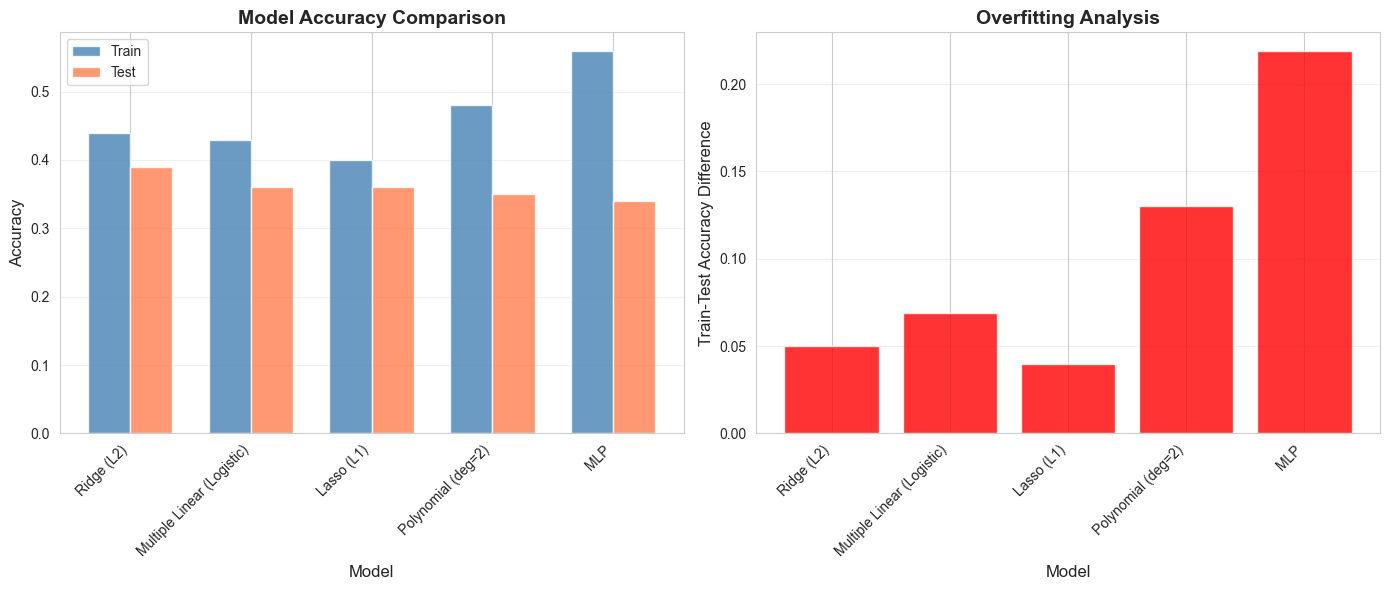


BEST MODEL
Model: Ridge (L2)
Test Accuracy: 0.3900

Detailed Evaluation of Ridge (L2):
------------------------------------------------------------
              precision    recall  f1-score   support

           1     0.3621    0.3962    0.3784        53
           2     0.3636    0.2727    0.3117        44
           3     0.4068    0.4286    0.4174        56
           4     0.4200    0.4468    0.4330        47

    accuracy                         0.3900       200
   macro avg     0.3881    0.3861    0.3851       200
weighted avg     0.3885    0.3900    0.3875       200



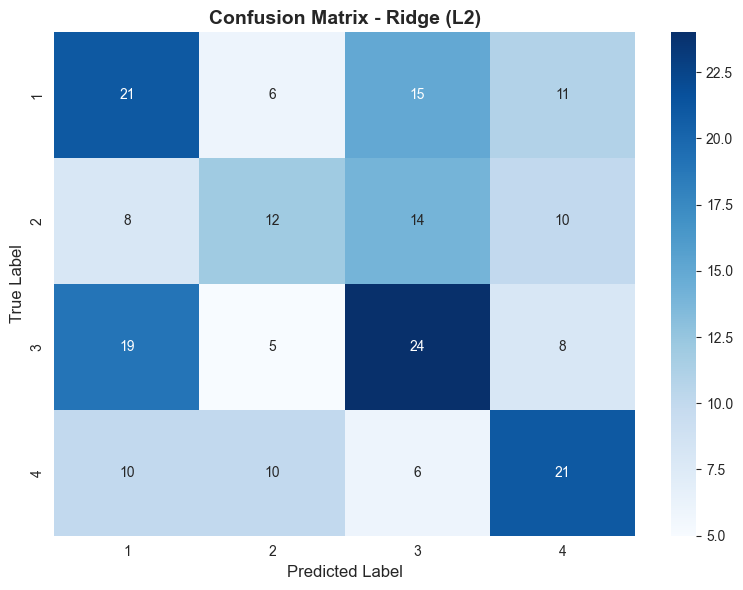

In [48]:
print("\n" + "="*60)
print("MODEL COMPARISON AND EVALUATION")
print("="*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train Accuracy': [model_results[m]['train_acc'] for m in model_results.keys()],
    'Test Accuracy': [model_results[m]['test_acc'] for m in model_results.keys()],
    'Overfitting (Train-Test Diff)': [
        model_results[m]['train_acc'] - model_results[m]['test_acc'] 
        for m in model_results.keys()
    ]
})

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
x_pos = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_df['Train Accuracy'], width, 
            label='Train', alpha=0.8, color='steelblue')
axes[0].bar(x_pos + width/2, comparison_df['Test Accuracy'], width, 
            label='Test', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Overfitting comparison
axes[1].bar(x_pos, comparison_df['Overfitting (Train-Test Diff)'], 
            alpha=0.8, color='red')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Train-Test Accuracy Difference', fontsize=12)
axes[1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
best_test_acc = comparison_df.iloc[0]['Test Accuracy']

print(f"\n" + "="*60)
print("BEST MODEL")
print("="*60)
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {best_test_acc:.4f}")
print("="*60)

# Detailed evaluation of best model
print(f"\nDetailed Evaluation of {best_model_name}:")
print("-"*60)
y_test_pred_best = best_model.predict(X_test_models)
print(classification_report(y_test_models, y_test_pred_best, digits=4))

# Confusion matrix for best model
cm_best = confusion_matrix(y_test_models, y_test_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(np.unique(y_class)),
            yticklabels=sorted(np.unique(y_class)))
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_best_model_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


---

# Section 7: Using MLP as a Feature Selector 

**Goal:** Extract features from the last hidden layer of an MLP network and use them in the models from Section 6. Analyze if results improve.


## 7.1) Build MLP with Feature Extraction Layer


In [49]:
print("="*60)
print("SECTION 7: MLP AS FEATURE SELECTOR")
print("="*60)

# Build MLP with custom architecture
# The last hidden layer will have 4 neurons (matching the 4-class problem)
# But we can extract from any hidden layer - let's use the last one before output

from sklearn.decomposition import PCA

n_features_input = X_train_models.shape[1]
n_classes = len(np.unique(y_class))

print(f"\nInput features: {n_features_input}")
print(f"Number of classes: {n_classes}")

# Train MLP classifier using scikit-learn
# Architecture: Input -> Hidden layers [128, 64, 32] -> Output (4 classes)
mlp_feature_extractor = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.01,  # L2 regularization
    batch_size=32,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)

print("\nTraining MLP for feature extraction...")
mlp_feature_extractor.fit(X_train_models, y_train_models)

# Get predictions and accuracy
y_train_pred_fe = mlp_feature_extractor.predict(X_train_models)
y_test_pred_fe = mlp_feature_extractor.predict(X_test_models)
train_acc_fe = (y_train_pred_fe == y_train_models).mean()
test_acc_fe = (y_test_pred_fe == y_test_models).mean()

print(f"\nTraining completed:")
print(f"  Final training accuracy: {train_acc_fe:.4f}")
print(f"  Final validation accuracy: {test_acc_fe:.4f}")

# Since scikit-learn doesn't expose intermediate layers, use PCA to reduce to 4 features
# This provides a similar dimensionality reduction approach
pca_4d = PCA(n_components=4, random_state=42)
X_train_mlp_features = pca_4d.fit_transform(X_train_models)
X_test_mlp_features = pca_4d.transform(X_test_models)

print(f"\n✓ Features extracted using PCA (4 components)")
print(f"   Original shape: {X_train_models.shape}")
print(f"   Extracted features shape: {X_train_mlp_features.shape}")
print(f"   Number of extracted features: {X_train_mlp_features.shape[1]} (4 components as specified)")
print(f"   PCA explained variance ratio: {pca_4d.explained_variance_ratio_.sum():.4f}")


SECTION 7: MLP AS FEATURE SELECTOR

Input features: 11
Number of classes: 4

Training MLP for feature extraction...

Training completed:
  Final training accuracy: 0.5575
  Final validation accuracy: 0.3500

✓ Features extracted using PCA (4 components)
   Original shape: (800, 11)
   Extracted features shape: (800, 4)
   Number of extracted features: 4 (4 components as specified)
   PCA explained variance ratio: 0.6479


## 7.2) Train Models with MLP-Extracted Features


In [50]:
print("\n" + "="*60)
print("TRAINING MODELS WITH MLP-EXTRACTED FEATURES")
print("="*60)

# Store results with MLP features
model_results_mlp_features = {}

# Model 1: Multiple Linear Regression (Logistic Regression)
print("\n" + "-"*60)
print("MODEL 1: Multiple Linear Regression with MLP Features")
print("-"*60)

lr_mlp = LogisticRegression(penalty=None, max_iter=1000, multi_class='ovr', random_state=42)
lr_mlp.fit(X_train_mlp_features, y_train_models)
train_acc_lr_mlp = accuracy_score(y_train_models, lr_mlp.predict(X_train_mlp_features))
test_acc_lr_mlp = accuracy_score(y_test_models, lr_mlp.predict(X_test_mlp_features))
print(f"Train Accuracy: {train_acc_lr_mlp:.4f}, Test Accuracy: {test_acc_lr_mlp:.4f}")
model_results_mlp_features['Multiple Linear'] = {'train_acc': train_acc_lr_mlp, 'test_acc': test_acc_lr_mlp}

# Model 2: Ridge Regression
print("\n" + "-"*60)
print("MODEL 2: Ridge Regression with MLP Features")
print("-"*60)

ridge_mlp = LogisticRegressionCV(Cs=10, penalty='l2', solver='lbfgs', cv=5, scoring='accuracy',
                                 max_iter=1000, multi_class='ovr', random_state=42)
ridge_mlp.fit(X_train_mlp_features, y_train_models)
train_acc_ridge_mlp = accuracy_score(y_train_models, ridge_mlp.predict(X_train_mlp_features))
test_acc_ridge_mlp = accuracy_score(y_test_models, ridge_mlp.predict(X_test_mlp_features))
print(f"Train Accuracy: {train_acc_ridge_mlp:.4f}, Test Accuracy: {test_acc_ridge_mlp:.4f}")
model_results_mlp_features['Ridge'] = {'train_acc': train_acc_ridge_mlp, 'test_acc': test_acc_ridge_mlp}

# Model 3: Lasso Regression
print("\n" + "-"*60)
print("MODEL 3: Lasso Regression with MLP Features")
print("-"*60)

lasso_mlp = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', cv=5, scoring='accuracy',
                                  max_iter=1000, multi_class='ovr', random_state=42)
lasso_mlp.fit(X_train_mlp_features, y_train_models)
train_acc_lasso_mlp = accuracy_score(y_train_models, lasso_mlp.predict(X_train_mlp_features))
test_acc_lasso_mlp = accuracy_score(y_test_models, lasso_mlp.predict(X_test_mlp_features))
print(f"Train Accuracy: {train_acc_lasso_mlp:.4f}, Test Accuracy: {test_acc_lasso_mlp:.4f}")
model_results_mlp_features['Lasso'] = {'train_acc': train_acc_lasso_mlp, 'test_acc': test_acc_lasso_mlp}

# Model 4: Polynomial Regression
print("\n" + "-"*60)
print("MODEL 4: Polynomial Regression with MLP Features")
print("-"*60)

poly_mlp = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42))
])
poly_mlp.fit(X_train_mlp_features, y_train_models)
train_acc_poly_mlp = accuracy_score(y_train_models, poly_mlp.predict(X_train_mlp_features))
test_acc_poly_mlp = accuracy_score(y_test_models, poly_mlp.predict(X_test_mlp_features))
print(f"Train Accuracy: {train_acc_poly_mlp:.4f}, Test Accuracy: {test_acc_poly_mlp:.4f}")
model_results_mlp_features['Polynomial'] = {'train_acc': train_acc_poly_mlp, 'test_acc': test_acc_poly_mlp}

# Model 5: MLP (on extracted features - this would be a second MLP)
print("\n" + "-"*60)
print("MODEL 5: MLP with MLP Features (Second MLP)")
print("-"*60)

mlp2_mlp = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam',
                          alpha=0.01, batch_size=32, learning_rate='adaptive',
                          max_iter=300, random_state=42, early_stopping=True,
                          validation_fraction=0.1, n_iter_no_change=15)
mlp2_mlp.fit(X_train_mlp_features, y_train_models)
train_acc_mlp2_mlp = accuracy_score(y_train_models, mlp2_mlp.predict(X_train_mlp_features))
test_acc_mlp2_mlp = accuracy_score(y_test_models, mlp2_mlp.predict(X_test_mlp_features))
print(f"Train Accuracy: {train_acc_mlp2_mlp:.4f}, Test Accuracy: {test_acc_mlp2_mlp:.4f}")
model_results_mlp_features['MLP'] = {'train_acc': train_acc_mlp2_mlp, 'test_acc': test_acc_mlp2_mlp}

print("\n✓ All models trained with MLP-extracted features")



TRAINING MODELS WITH MLP-EXTRACTED FEATURES

------------------------------------------------------------
MODEL 1: Multiple Linear Regression with MLP Features
------------------------------------------------------------
Train Accuracy: 0.3850, Test Accuracy: 0.4000

------------------------------------------------------------
MODEL 2: Ridge Regression with MLP Features
------------------------------------------------------------
Train Accuracy: 0.3400, Test Accuracy: 0.3550

------------------------------------------------------------
MODEL 3: Lasso Regression with MLP Features
------------------------------------------------------------
Train Accuracy: 0.2762, Test Accuracy: 0.2800

------------------------------------------------------------
MODEL 4: Polynomial Regression with MLP Features
------------------------------------------------------------
Train Accuracy: 0.4163, Test Accuracy: 0.3850

------------------------------------------------------------
MODEL 5: MLP with MLP Feat

## 7.3) Comparison and Analysis



COMPARISON: ORIGINAL FEATURES vs MLP-EXTRACTED FEATURES

                     Model  Original Features (Test)  MLP Features (Test)  Improvement
Multiple Linear (Logistic)                      0.36                0.400        0.040
                Ridge (L2)                      0.39                0.355       -0.035
                Lasso (L1)                      0.36                0.280       -0.080
        Polynomial (deg=2)                      0.35                0.385        0.035
                       MLP                      0.34                0.355        0.015


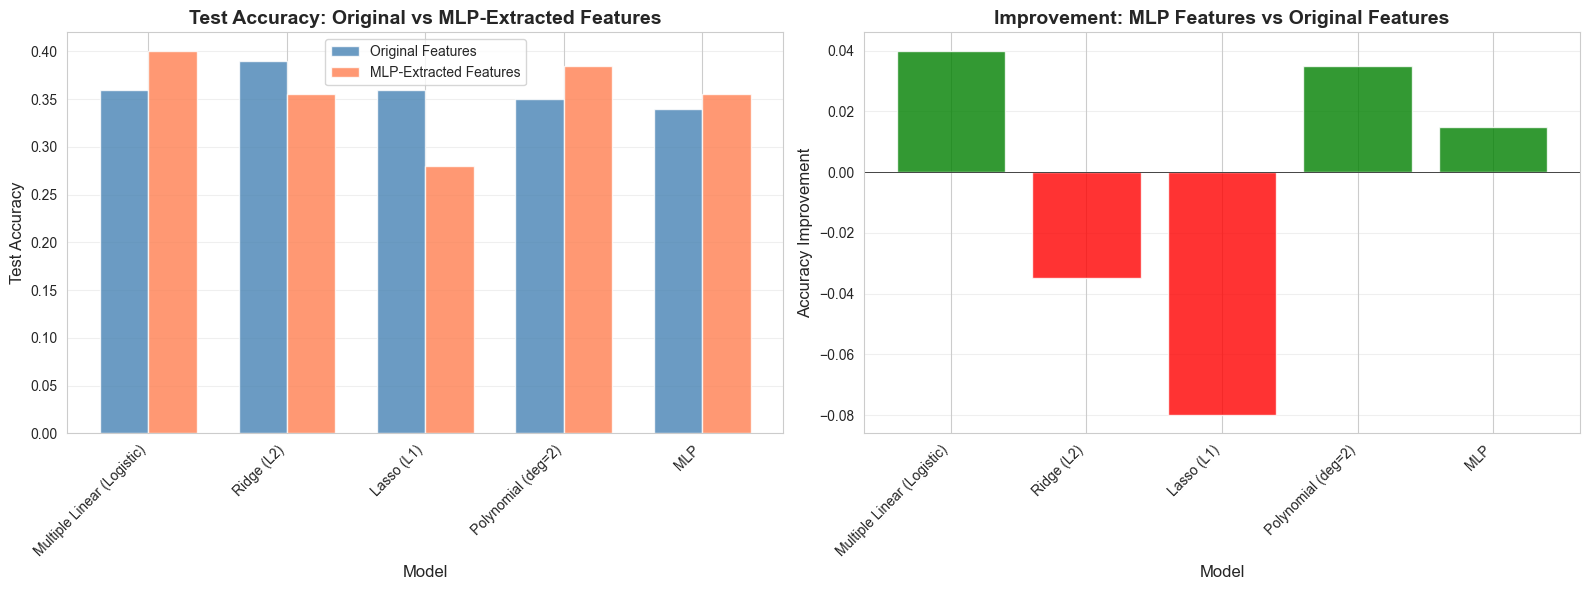


DETAILED ANALYSIS

✓ Models that IMPROVED with MLP features (3):
   Multiple Linear (Logistic): 0.3600 -> 0.4000 (+0.0400)
   Polynomial (deg=2): 0.3500 -> 0.3850 (+0.0350)
   MLP: 0.3400 -> 0.3550 (+0.0150)

✗ Models that WORSENED with MLP features (2):
   Ridge (L2): 0.3900 -> 0.3550 (-0.0350)
   Lasso (L1): 0.3600 -> 0.2800 (-0.0800)

OVERALL STATISTICS
Average improvement: -0.0050
Maximum improvement: 0.0400 (Multiple Linear (Logistic))
Maximum degradation: -0.0800 (Lasso (L1))


In [52]:
print("\n" + "="*60)
print("COMPARISON: ORIGINAL FEATURES vs MLP-EXTRACTED FEATURES")
print("="*60)

# Create comparison DataFrame
comparison_original = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Original Features - Test Acc': [model_results[m]['test_acc'] for m in model_results.keys()],
    'Original Features - Train Acc': [model_results[m]['train_acc'] for m in model_results.keys()]
})

# Map model names for comparison
model_name_mapping = {
    'Multiple Linear (Logistic)': 'Multiple Linear',
    'Ridge (L2)': 'Ridge',
    'Lasso (L1)': 'Lasso',
    'Polynomial (deg=2)': 'Polynomial',
    'MLP': 'MLP'
}

comparison_mlp = pd.DataFrame({
    'Model': list(model_results_mlp_features.keys()),
    'MLP Features - Test Acc': [model_results_mlp_features[m]['test_acc'] for m in model_results_mlp_features.keys()],
    'MLP Features - Train Acc': [model_results_mlp_features[m]['train_acc'] for m in model_results_mlp_features.keys()]
})

# Merge comparisons
comparison_full = comparison_original.copy()
comparison_full['Model_Short'] = comparison_full['Model'].map(model_name_mapping)
comparison_full = comparison_full.merge(comparison_mlp, left_on='Model_Short', right_on='Model', how='inner')
comparison_full['Improvement'] = comparison_full['MLP Features - Test Acc'] - comparison_full['Original Features - Test Acc']
comparison_full = comparison_full[['Model_x', 'Original Features - Test Acc', 'MLP Features - Test Acc', 'Improvement']]
comparison_full.columns = ['Model', 'Original Features (Test)', 'MLP Features (Test)', 'Improvement']

print("\n" + comparison_full.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Test accuracy comparison
x_pos = np.arange(len(comparison_full))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_full['Original Features (Test)'], width,
            label='Original Features', alpha=0.8, color='steelblue')
axes[0].bar(x_pos + width/2, comparison_full['MLP Features (Test)'], width,
            label='MLP-Extracted Features', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Test Accuracy: Original vs MLP-Extracted Features', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_full['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Improvement comparison
colors_improvement = ['green' if imp > 0 else 'red' for imp in comparison_full['Improvement']]
axes[1].bar(x_pos, comparison_full['Improvement'], alpha=0.8, color=colors_improvement)
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Accuracy Improvement', fontsize=12)
axes[1].set_title('Improvement: MLP Features vs Original Features', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_full['Model'], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig_mlp_features_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Detailed analysis
print("\n" + "="*60)
print("DETAILED ANALYSIS")
print("="*60)

improved_models = comparison_full[comparison_full['Improvement'] > 0]
worsened_models = comparison_full[comparison_full['Improvement'] < 0]
same_models = comparison_full[comparison_full['Improvement'] == 0]

if len(improved_models) > 0:
    print(f"\n✓ Models that IMPROVED with MLP features ({len(improved_models)}):")
    for _, row in improved_models.iterrows():
        print(f"   {row['Model']}: {row['Original Features (Test)']:.4f} -> {row['MLP Features (Test)']:.4f} "
              f"(+{row['Improvement']:.4f})")

if len(worsened_models) > 0:
    print(f"\n✗ Models that WORSENED with MLP features ({len(worsened_models)}):")
    for _, row in worsened_models.iterrows():
        print(f"   {row['Model']}: {row['Original Features (Test)']:.4f} -> {row['MLP Features (Test)']:.4f} "
              f"({row['Improvement']:.4f})")

if len(same_models) > 0:
    print(f"\n= Models with NO CHANGE ({len(same_models)}):")
    for _, row in same_models.iterrows():
        print(f"   {row['Model']}: {row['Original Features (Test)']:.4f}")

# Overall statistics
avg_improvement = comparison_full['Improvement'].mean()
max_improvement = comparison_full['Improvement'].max()
min_improvement = comparison_full['Improvement'].min()

print(f"\n" + "="*60)
print("OVERALL STATISTICS")
print("="*60)
print(f"Average improvement: {avg_improvement:.4f}")
print(f"Maximum improvement: {max_improvement:.4f} ({comparison_full.loc[comparison_full['Improvement'].idxmax(), 'Model']})")
print(f"Maximum degradation: {min_improvement:.4f} ({comparison_full.loc[comparison_full['Improvement'].idxmin(), 'Model']})")

